In [1]:
# Set up libraries
import numpy as np
import pdb as pdb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# import matplotlib.colormaps as cmaps
import time
import laspy
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy import stats

In [2]:
# Set up color tables
x = np.linspace(0.0, 1.0, 256)
rainbow_rgb = plt.get_cmap("rainbow")(x)[np.newaxis, :, :3]

In [3]:
# Define up constants
air_index_of_refraction = 1.0003
c = 2.99792458e8   
number_of_waveform_files = 100000

In [4]:
# Open AOP Pulsewaves file 
# Switch between windows and mac; also between files for clustering/linear regression
# aop_data_dir = 'C:\\Users\\felixyu\\Documents\\GitHub\\Neon-Pls-Wvs-Analysis\\data\\'
# aop_data_dir = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/'
# waveform_file = aop_data_dir + 'lidar.pls'
aop_data_dir = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'
waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L008-1_2019081112.plz'
# point_cloud_file_las = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L006-1_2017081715_unclassified_point_cloud.las'
# point_cloud_file_laz = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L006-1_2017081715_unclassified_point_cloud.laz'

In [5]:
# Define a function to detect peaks in the waveform
def waveform_peak_detection(waveform,waveform_intensity_threshold):
    # Define x grid
    x_grid = np.arange(0.0,len(waveform),1.0)

    # Calculate 1st and 2nd derivatives
    deriv_1st = np.gradient(waveform,axis=0,edge_order=1)
    deriv_2nd = np.gradient(deriv_1st,axis=0,edge_order=1)

    #Find locations where 1st derivative crosses 0: (deriv_1st[i] * deriv_1st[i-1] = negative value)
    mult_shift_deriv_1st = deriv_1st * np.roll(deriv_1st,1)
    zero_slope_aoi = np.argwhere(mult_shift_deriv_1st <= 0.0)
    zero_slope_aoi = zero_slope_aoi[:,0]
    zero_slope_count = len(zero_slope_aoi)
    if zero_slope_count > 0:
        zero_slope_aoi = np.reshape(zero_slope_aoi,len(zero_slope_aoi))

    if zero_slope_count == 0:
        return_location_count = 0
        return_peak_location_list = -9999
        return_location_list_x = -9999
        return_intensity_list = -9999    
    else:
        if zero_slope_count == 1:    
            if zero_slope_aoi == 0:
                return_location_count = 0
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            else:
                if deriv_2nd[zero_slope_aoi] < 0.0:
                    return_location_count = 1
                    return_peak_location_list = zero_slope_aoi
                    return_location_list_x = x_grid[zero_slope_aoi]
                    return_intensity_list = waveform[zero_slope_aoi]               
                else:
                    return_location_count = 0
                    return_peak_location_list = -9999
                    return_location_list_x = -9999
                    return_intensity_list = -9999    
        else:
                #Remove bin 0 if included in list
            if zero_slope_aoi[0] == 0:
                zero_slope_aoi = zero_slope_aoi[1:zero_slope_count]
                zero_slope_count = zero_slope_count - 1        
                #Remove sequential bins if included in list and keep first                
            zero_slope_aoi_diff = zero_slope_aoi - np.roll(zero_slope_aoi,1)
            good_zero_slope_aoi = np.argwhere(zero_slope_aoi_diff != 1)
            good_zero_slope_aoi = np.reshape(good_zero_slope_aoi,len(good_zero_slope_aoi))
            zero_slope_aoi = zero_slope_aoi[good_zero_slope_aoi]
            zero_slope_count = len(good_zero_slope_aoi)
            zero_slope_aoi_diff = 0
            good_zero_slope_aoi = 0       
                #Return peaks will have a negative 2nd derivative
            peak_locations_aoi = np.argwhere(deriv_2nd[zero_slope_aoi] < 0.0)
            return_location_count = len(peak_locations_aoi)
            if return_location_count > 0:
                peak_locations_aoi = peak_locations_aoi[:,0]
                peak_locations_aoi = np.reshape(peak_locations_aoi,len(peak_locations_aoi))
                return_peak_location_list = zero_slope_aoi[peak_locations_aoi]
                return_location_list_x = x_grid[zero_slope_aoi[peak_locations_aoi]]
                return_intensity_list = waveform[return_peak_location_list]
            else:
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            peak_locations_aoi = 0

    if return_location_count > 0:
        return_peak_location_list = np.reshape(return_peak_location_list,return_location_count)
        return_location_list_x = np.reshape(return_location_list_x,return_location_count)
        return_intensity_list = np.reshape(return_intensity_list,return_location_count)
                     
        #Remove peaks with peak location at first 2 bins
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_peak_location_list > 1)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0                    

        #Check intensity values for valid peaks
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_intensity_list >= waveform_intensity_threshold)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0    
    
    x_grid = 0
    deriv_1st = 0
    deriv_2nd = 0
    mult_shift_deriv_1st = 0
    zero_slope_aoi = 0
    waveform = 0
    return return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list

In [6]:
def read_NEONAOP_pulsewaves_pulse_information(pls_file, number_of_waveform_files=number_of_waveform_files):
    """
    Reads PulseWaves (PLS) file metadata and pulse information, returning
    instrument name, number of pulses, anchor positions, wave offsets, etc.
    """

    readbin_pls_file = open(pls_file, "rb")
    readbin_pls_file.seek(0, 0)

    # 1. Read PulseWaves Header (many single-value fields).
    file_signature = np.fromfile(readbin_pls_file, np.int8, 16)  # 16 bytes
    global_parameters = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    file_source_id = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    project_id_guid_data1 = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    project_id_guid_data2 = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    project_id_guid_data3 = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    project_id_guid_data4 = np.fromfile(readbin_pls_file, np.uint8, 8)  # 8 bytes
    system_identifier = np.fromfile(readbin_pls_file, np.int8, 64)      # 64 bytes
    generating_software = np.fromfile(readbin_pls_file, np.int8, 64)    # 64 bytes
    file_creation_day_of_year = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    file_creation_year = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    version_major = int(np.fromfile(readbin_pls_file, np.uint8, 1)[0])
    version_minor = int(np.fromfile(readbin_pls_file, np.uint8, 1)[0])
    header_size = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    offset_to_pulse_data = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    number_of_pulses = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    pulse_format = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    pulse_attributes = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    pulse_size = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    pulse_compression = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    reserved = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    number_of_variable_length_records = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    number_of_appended_variable_length_records = int(np.fromfile(readbin_pls_file, np.int32, 1)[0])
    T_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    T_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_T = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    max_T = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    x_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    y_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    z_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    x_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    y_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    z_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_x = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    max_x = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_y = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    max_y = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_z = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    max_z = float(np.fromfile(readbin_pls_file, np.double, 1)[0])

    # 2. Read variable length records
    vlr_user_id = []
    vlr_record_id = []
    vlr_reserved = []
    vlr_record_length_after_header = []
    vlr_description = []
    vlr_data = []

    pulse_descriptor_size = []
    pulse_descriptor_reserved = []
    pulse_descriptor_optical_center_to_anchor_point = []
    pulse_descriptor_number_of_extra_wave_bytes = []
    pulse_descriptor_number_of_samplings = []
    pulse_descriptor_sample_units = []
    pulse_descriptor_compression = []
    pulse_descriptor_scanner_index = []
    pulse_descriptor_description = []

    sampling_record_pulse_descriptor_index_lookup = []
    sampling_record_size = []
    sampling_record_reserved = []
    sampling_record_type = []
    sampling_record_channel = []
    sampling_record_unused = []
    sampling_record_bits_for_duration_from_anchor = []
    sampling_record_scale_for_duration_from_anchor = []
    sampling_record_offset_for_duration_from_anchor = []
    sampling_record_bits_for_number_of_segments = []
    sampling_record_bits_for_number_of_samples = []
    sampling_record_number_of_segments = []
    sampling_record_number_of_samples = []
    sampling_record_bits_per_sample = []
    sampling_record_lookup_table_index = []
    sampling_record_sample_units = []
    sampling_record_compression = []
    sampling_record_description = []

    num_pulse_descriptor_records = 0

    for i in range(number_of_variable_length_records):
        # Read 1 VLR
        vlr_user_id.append(np.fromfile(readbin_pls_file, np.int8, 16))
        this_record_id = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
        vlr_record_id.append(this_record_id)

        vlr_reserved.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
        this_record_length = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
        vlr_record_length_after_header.append(this_record_length)

        vlr_description.append(np.fromfile(readbin_pls_file, np.int8, 64))

        if (this_record_id >= 100001 and this_record_id < 100255):
            # Scanner block
            scanner_size = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_reserved = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_instrument = np.fromfile(readbin_pls_file, np.int8, 64)
            scanner_serial = np.fromfile(readbin_pls_file, np.int8, 64)
            scanner_wave_length = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_outgoing_pulse_width = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_scan_pattern = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_number_of_mirror_facets = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_scan_frequency = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_scan_angle_min = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_scan_angle_max = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_pulse_frequency = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_beam_diameter_at_exit_apertrue = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_beam_divergence = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_minimal_range = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_maximal_range = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_description = np.fromfile(readbin_pls_file, np.int8, 64)
            continue

        elif (this_record_id >= 20001 and this_record_id < 200255):
            # Pulse descriptor
            pulse_descriptor_index = this_record_id - 200000
            pulse_descriptor_size.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_reserved.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_optical_center_to_anchor_point.append(int(np.fromfile(readbin_pls_file, np.int32, 1)[0]))
            pulse_descriptor_number_of_extra_wave_bytes.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
            pulse_descriptor_number_of_samplings.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
            pulse_descriptor_sample_units.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))
            pulse_descriptor_compression.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_scanner_index.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_description.append(np.fromfile(readbin_pls_file, np.int8, 64))
            num_pulse_descriptor_records += 1

            # Read sampling records
            for j in range(pulse_descriptor_number_of_samplings[-1]):
                sampling_record_pulse_descriptor_index_lookup.append(pulse_descriptor_index)

                sampling_record_size.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_reserved.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_type.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_channel.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_unused.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))

                sampling_record_bits_for_duration_from_anchor.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_scale_for_duration_from_anchor.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))
                sampling_record_offset_for_duration_from_anchor.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))

                sampling_record_bits_for_number_of_segments.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_bits_for_number_of_samples.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))

                sampling_record_number_of_segments.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
                sampling_record_number_of_samples.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_bits_per_sample.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
                sampling_record_lookup_table_index.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
                sampling_record_sample_units.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))
                sampling_record_compression.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_description.append(np.fromfile(readbin_pls_file, np.int8, 64))

            continue
        else:
            # General-purpose VLR data
            vlr_data.append(np.fromfile(readbin_pls_file, np.uint8, this_record_length))

    # 3. Convert lists into NumPy arrays (reshape as needed)
    pulse_descriptor_size_array = np.array(pulse_descriptor_size, dtype=np.uint32)
    pulse_descriptor_reserved_array = np.array(pulse_descriptor_reserved, dtype=np.uint32)
    pulse_descriptor_optical_center_to_anchor_point_array = np.array(
        pulse_descriptor_optical_center_to_anchor_point, dtype=np.int32
    )
    pulse_descriptor_number_of_extra_wave_bytes_array = np.array(
        pulse_descriptor_number_of_extra_wave_bytes, dtype=np.uint16
    )
    pulse_descriptor_number_of_samplings_array = np.array(
        pulse_descriptor_number_of_samplings, dtype=np.uint16
    )
    pulse_descriptor_sample_units_array = np.array(pulse_descriptor_sample_units, dtype=np.float32)
    pulse_descriptor_compression_array = np.array(pulse_descriptor_compression, dtype=np.uint32)
    pulse_descriptor_scanner_index_array = np.array(pulse_descriptor_scanner_index, dtype=np.uint32)

    sampling_record_pulse_descriptor_index_lookup_array = np.array(
        sampling_record_pulse_descriptor_index_lookup, dtype=np.int64
    )
    sampling_record_size_array = np.array(sampling_record_size, dtype=np.uint32)
    sampling_record_reserved_array = np.array(sampling_record_reserved, dtype=np.uint32)
    sampling_record_type_array = np.array(sampling_record_type, dtype=np.uint8)
    sampling_record_channel_array = np.array(sampling_record_channel, dtype=np.uint8)
    sampling_record_unused_array = np.array(sampling_record_unused, dtype=np.uint8)
    sampling_record_bits_for_duration_from_anchor_array = np.array(
        sampling_record_bits_for_duration_from_anchor, dtype=np.uint8
    )
    sampling_record_scale_for_duration_from_anchor_array = np.array(
        sampling_record_scale_for_duration_from_anchor, dtype=np.float32
    )
    sampling_record_offset_for_duration_from_anchor_array = np.array(
        sampling_record_offset_for_duration_from_anchor, dtype=np.float32
    )
    sampling_record_bits_for_number_of_segments_array = np.array(
        sampling_record_bits_for_number_of_segments, dtype=np.uint8
    )
    sampling_record_bits_for_number_of_samples_array = np.array(
        sampling_record_bits_for_number_of_samples, dtype=np.uint8
    )
    sampling_record_number_of_segments_array = np.array(
        sampling_record_number_of_segments, dtype=np.uint16
    )
    sampling_record_number_of_samples_array = np.array(
        sampling_record_number_of_samples, dtype=np.uint32
    )
    sampling_record_bits_per_sample_array = np.array(sampling_record_bits_per_sample, dtype=np.uint16)
    sampling_record_lookup_table_index_array = np.array(
        sampling_record_lookup_table_index, dtype=np.uint16
    )
    sampling_record_sample_units_array = np.array(sampling_record_sample_units, dtype=np.float32)
    sampling_record_compression_array = np.array(sampling_record_compression, dtype=np.uint32)

    # 4. Fix instrument name logic (example: Optech => T_offset=0 if needed)
    instrument_name = str(system_identifier, "UTF-8")  # decode from bytes

    # For certain instruments, T_offset = 0
    if instrument_name.startswith("Galaxy"):
        instrument_name = instrument_name[:6]  # "Galaxy"
        T_offset = 0.0
    if instrument_name.startswith("ALTM GEMINI"):
        instrument_name = "Gemini"
        T_offset = 0.0

    # 5. Prepare arrays to hold pulse info
    gps_timestamp_T_array = np.zeros(number_of_pulses, dtype=np.int64)
    offset_to_waves_array = np.zeros(number_of_pulses, dtype=np.int64)
    anchor_X_array = np.zeros(number_of_pulses, dtype=np.int32)
    anchor_Y_array = np.zeros(number_of_pulses, dtype=np.int32)
    anchor_Z_array = np.zeros(number_of_pulses, dtype=np.int32)
    target_X_array = np.zeros(number_of_pulses, dtype=np.int32)
    target_Y_array = np.zeros(number_of_pulses, dtype=np.int32)
    target_Z_array = np.zeros(number_of_pulses, dtype=np.int32)
    first_returning_sample_array = np.zeros(number_of_pulses, dtype=np.int16)
    last_returning_sample_array = np.zeros(number_of_pulses, dtype=np.int16)
    pulse_data_array = np.zeros((number_of_pulses, 2), dtype=np.int8)
    intensity_array = np.zeros(number_of_pulses, dtype=np.int8)
    classification_array = np.zeros(number_of_pulses, dtype=np.int8)

    gps_timestamp_array = np.zeros(number_of_pulses, dtype=np.float64)
    xyz_anchor_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    xyz_target_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    pulse_descriptor_index_array = np.zeros(number_of_pulses, dtype=np.float64)

    dxdydz_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    xyz_first_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    xyz_last_array = np.zeros((number_of_pulses, 3), dtype=np.float64)

    # 6. Read PLS Pulse Data
    count = 0
    for iPulse in range(number_of_pulses):
        # Compute file offset for this pulse
        pls_file_offset = offset_to_pulse_data + iPulse * pulse_size
        readbin_pls_file.seek(pls_file_offset, 0)

        # Read single pulse record fields (each is 1 value, so index [0])
        gps_timestamp_T_array[iPulse] = np.fromfile(readbin_pls_file, np.int64, 1)[0]
        offset_to_waves_array[iPulse] = np.fromfile(readbin_pls_file, np.int64, 1)[0]
        anchor_X_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        anchor_Y_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        anchor_Z_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        target_X_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        target_Y_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        target_Z_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        first_returning_sample_array[iPulse] = np.fromfile(readbin_pls_file, np.int16, 1)[0]
        last_returning_sample_array[iPulse] = np.fromfile(readbin_pls_file, np.int16, 1)[0]

        # pulse_data_array has 2 int8's
        pulse_data_array[iPulse, :] = np.fromfile(readbin_pls_file, np.int8, 2)

        intensity_array[iPulse] = np.fromfile(readbin_pls_file, np.int8, 1)[0]
        classification_array[iPulse] = np.fromfile(readbin_pls_file, np.int8, 1)[0]

        # Compute scaled values
        gps_timestamp_array[iPulse] = float(gps_timestamp_T_array[iPulse]) * T_scale_factor + T_offset
        xyz_anchor_array[iPulse, 0] = float(anchor_X_array[iPulse]) * x_scale_factor + x_offset
        xyz_anchor_array[iPulse, 1] = float(anchor_Y_array[iPulse]) * y_scale_factor + y_offset
        xyz_anchor_array[iPulse, 2] = float(anchor_Z_array[iPulse]) * z_scale_factor + z_offset

        xyz_target_array[iPulse, 0] = float(target_X_array[iPulse]) * x_scale_factor + x_offset
        xyz_target_array[iPulse, 1] = float(target_Y_array[iPulse]) * y_scale_factor + y_offset
        xyz_target_array[iPulse, 2] = float(target_Z_array[iPulse]) * z_scale_factor + z_offset

        pulse_descriptor_index_array[iPulse] = pulse_data_array[iPulse, 0]

        # Calculate dx, dy, dz
        dxdydz_array[iPulse, 0] = (xyz_target_array[iPulse, 0] - xyz_anchor_array[iPulse, 0]) / 1000.0
        dxdydz_array[iPulse, 1] = (xyz_target_array[iPulse, 1] - xyz_anchor_array[iPulse, 1]) / 1000.0
        dxdydz_array[iPulse, 2] = (xyz_target_array[iPulse, 2] - xyz_anchor_array[iPulse, 2]) / 1000.0

        # Calculate first/last sample positions
        first_return = float(first_returning_sample_array[iPulse])
        last_return = float(last_returning_sample_array[iPulse])

        xyz_first_array[iPulse, 0] = xyz_anchor_array[iPulse, 0] + first_return * dxdydz_array[iPulse, 0]
        xyz_first_array[iPulse, 1] = xyz_anchor_array[iPulse, 1] + first_return * dxdydz_array[iPulse, 1]
        xyz_first_array[iPulse, 2] = xyz_anchor_array[iPulse, 2] + first_return * dxdydz_array[iPulse, 2]

        xyz_last_array[iPulse, 0] = xyz_anchor_array[iPulse, 0] + last_return * dxdydz_array[iPulse, 0]
        xyz_last_array[iPulse, 1] = xyz_anchor_array[iPulse, 1] + last_return * dxdydz_array[iPulse, 1]
        xyz_last_array[iPulse, 2] = xyz_anchor_array[iPulse, 2] + last_return * dxdydz_array[iPulse, 2]

        # Just a safety check for user-supplied limit
        count += 1
        if count > number_of_waveform_files:
            break

    readbin_pls_file.close()

    # 7. Return whatever pieces you need downstream
    return (instrument_name,
            number_of_pulses,
            xyz_anchor_array,
            dxdydz_array,
            xyz_first_array,
            xyz_last_array,
            offset_to_pulse_data,
            pulse_size,
            T_scale_factor,
            T_offset,
            x_scale_factor,
            x_offset,
            y_scale_factor,
            y_offset,
            z_scale_factor,
            z_offset,
            sampling_record_pulse_descriptor_index_lookup_array,
            pulse_descriptor_optical_center_to_anchor_point_array,
            pulse_descriptor_number_of_extra_wave_bytes_array,
            pulse_descriptor_number_of_samplings_array,
            sampling_record_bits_for_duration_from_anchor_array,
            sampling_record_scale_for_duration_from_anchor_array,
            sampling_record_offset_for_duration_from_anchor_array,
            sampling_record_bits_for_number_of_segments_array,
            sampling_record_bits_for_number_of_samples_array,
            sampling_record_number_of_segments_array,
            sampling_record_number_of_samples_array,
            sampling_record_bits_per_sample_array)


In [7]:
# Read waveform information for AOP
# Read pulse ancillary info from waveform file: origin/platform/anchor location, ray dxdydz, first and last bin geolocation
start = time.time()
waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'

instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information(pls_file) 

if (instrument_name == 'Gemini'):
    beam_footprint = 0.8
elif (instrument_name == 'Galaxy'):
    beam_footprint = 0.25
else:
    beam_footprint = 0.0
    print("Beam Footprint not found")

utmEasting_bin0_array = xyz_bin0_array[:,0]
utmNorthing_bin0_array = xyz_bin0_array[:,1]
elevation_bin0_array = xyz_bin0_array[:,2]
utmEasting_lastbin_array = xyz_lastbin_array[:,0]
utmNorthing_lastbin_array = xyz_lastbin_array[:,1]
elevation_lastbin_array = xyz_lastbin_array[:,2]
end = time.time()
print(instrument_name)
print(beam_footprint)
print(number_of_pulses)
print(pulse_size)

# Mask each array with 0.0 to print out accurate easting and northing information
masked_utm_easting_arr = np.ma.masked_equal(utmEasting_bin0_array, 0.0)
masked_utm_northing_arr = np.ma.masked_equal(utmNorthing_bin0_array, 0.0)
print(np.min(masked_utm_easting_arr),np.max(utmEasting_bin0_array))
print(np.min(masked_utm_northing_arr),np.max(utmNorthing_bin0_array))
print(np.min(elevation_bin0_array),np.max(elevation_bin0_array))
print(np.min(utmEasting_lastbin_array),np.max(utmEasting_lastbin_array))
print(np.min(utmNorthing_lastbin_array),np.max(utmNorthing_lastbin_array))
print(np.min(elevation_lastbin_array),np.max(elevation_lastbin_array))
print(f"Total runtime {end - start}s")

Gemini
0.8
26291039
48
727186.2278800001 727815.4552800003
4695772.874319997 4695922.289080002
0.0 225.70291999999995
0.0 727817.2758000003
0.0 4695922.408810002
0.0 220.20911999999976
Total runtime 8.678623914718628s


In [23]:
min_intensity1 = 400.0
max_intensity1 = 75.0

waveform_rgb_lut1 = np.int16((waveform_z_abs_firstreturn_array - min_intensity1) / max_intensity1 * 255)
low_aoi = np.argwhere(waveform_rgb_lut1 < 0)
if len(low_aoi) > 0:
    waveform_rgb_lut1[low_aoi] = 0
high_aoi = np.argwhere(waveform_rgb_lut1 > 255)
if len(high_aoi) > 0:
    waveform_rgb_lut1[high_aoi] = 255
    

NameError: name 'waveform_z_abs_firstreturn_array' is not defined

In [8]:
# Define a function to read a pulsewaves waveform for a single pulse
def read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array):    
    readbin_pls_file.seek(0,0)
    readbin_wvs_file.seek(0,0)
    
    # Read pulse record
    pls_file_offset = int(offset_to_pulse_data + iPulse * pulse_size) 
    readbin_pls_file.seek(pls_file_offset, 0)
    
    gps_timestamp_T = np.fromfile(readbin_pls_file, np.int64, 1)
    gps_timestamp_T = gps_timestamp_T[0]  # Now it's a scalar
    offset_to_waves = np.fromfile(readbin_pls_file, np.int64, 1)
    offset_to_waves = offset_to_waves[0]
    
    anchor_X = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    anchor_Y = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    anchor_Z = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    target_X = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    target_Y = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    target_Z = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    first_returning_sample = np.fromfile(readbin_pls_file, np.int16, 1)[0]
    last_returning_sample  = np.fromfile(readbin_pls_file, np.int16, 1)[0]
    pulse_data = np.fromfile(readbin_pls_file,np.int8,2)  
    intensity = np.fromfile(readbin_pls_file,np.int8,1)
    classification = np.fromfile(readbin_pls_file,np.int8,1)
    
    gps_timestamp = float(gps_timestamp_T) * T_scale_factor + T_offset
    x_anchor     = float(anchor_X) * x_scale_factor + x_offset
    y_anchor     = float(anchor_Y) * y_scale_factor + y_offset
    z_anchor     = float(anchor_Z) * z_scale_factor + z_offset
    x_target     = float(target_X) * x_scale_factor + x_offset
    y_target     = float(target_Y) * y_scale_factor + y_offset
    z_target     = float(target_Z) * z_scale_factor + z_offset      
    pulse_descriptor_index = pulse_data[0]
    dx = (x_target - x_anchor) / 1000.0
    dy = (y_target - y_anchor) / 1000.0
    dz = (z_target - z_anchor) / 1000.0
    x_first = x_anchor + float(first_returning_sample) * dx
    y_first = y_anchor + float(first_returning_sample) * dy
    z_first = z_anchor + float(first_returning_sample) * dz
    x_last = x_anchor + float(last_returning_sample) * dx
    y_last = y_anchor + float(last_returning_sample) * dy
    z_last = z_anchor + float(last_returning_sample) * dz      
    multiple_segments_bool = False
    
    #read waveforms
    pulse_descriptor_aoi = np.argwhere(sampling_record_pulse_descriptor_index_lookup_array == pulse_descriptor_index)
    pulse_descriptor_aoi = np.reshape(pulse_descriptor_aoi,len(pulse_descriptor_aoi))

    optical_center_to_anchor_point = pulse_descriptor_optical_center_to_anchor_point_array[pulse_descriptor_index-1]
    number_of_extra_wave_bytes = pulse_descriptor_number_of_extra_wave_bytes_array[pulse_descriptor_index-1]
    number_of_samplings = pulse_descriptor_number_of_samplings_array[pulse_descriptor_index-1]

    bits_for_duration_from_anchor_array = sampling_record_bits_for_duration_from_anchor_array[pulse_descriptor_aoi]
    scale_for_duration_from_anchor_array = sampling_record_scale_for_duration_from_anchor_array[pulse_descriptor_aoi]
    offset_for_duration_from_anchor_array = sampling_record_offset_for_duration_from_anchor_array[pulse_descriptor_aoi]
    bits_for_number_of_segments_array = sampling_record_bits_for_number_of_segments_array[pulse_descriptor_aoi]
    bits_for_number_of_samples_array = sampling_record_bits_for_number_of_samples_array[pulse_descriptor_aoi]
    number_of_segments_array = sampling_record_number_of_segments_array[pulse_descriptor_aoi]
    number_of_samples_array = sampling_record_number_of_samples_array[pulse_descriptor_aoi]
    bits_per_sample_array = sampling_record_bits_per_sample_array[pulse_descriptor_aoi]    

    wvs_file_offset = offset_to_waves
    readbin_wvs_file.seek(offset_to_waves, 0)

    if(number_of_extra_wave_bytes > 0):
        extra_wave_bytes = np.fromfile(readbin_wvs_file,np.int8,number_of_extra_wave_bytes)
        
    for iSampling in range(number_of_samplings):
        # print(f"Num of samplings: {number_of_samplings}")
        if bits_for_number_of_segments_array[iSampling] != 0:
            number_of_segments_number_of_bits = bits_for_number_of_segments_array[iSampling]
            if number_of_segments_number_of_bits[0] == 8:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint8,1)
            elif number_of_segments_number_of_bits[0] == 16:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint16,1)            
            elif number_of_segments_number_of_bits[0] == 32:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint32,1)
        else:
            number_of_segments = number_of_segments_array[iSampling]    

        waveform_segments_array = np.zeros((500,number_of_segments))
        number_of_samples_array = np.zeros(number_of_segments)
        scaled_duration_from_anchor_for_segment_array = np.zeros(number_of_segments)                    

        for iSegment in range(number_of_segments):
            # print(f"Num of segments: {number_of_segments}")
            duration_from_anchor_number_of_bits = bits_for_duration_from_anchor_array[iSampling]
            if duration_from_anchor_number_of_bits == 8:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint8,1)
            elif duration_from_anchor_number_of_bits == 16:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint16,1)            
            elif duration_from_anchor_number_of_bits == 32:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint32,1)

            if bits_for_number_of_samples_array[iSampling] != 0:
                number_of_samples_number_of_bits = bits_for_number_of_samples_array[iSampling]    
                if number_of_samples_number_of_bits == 8:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint8,1)
                elif number_of_samples_number_of_bits == 16:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint16,1)            
                elif number_of_samples_number_of_bits == 32:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint32,1)
            else:
                number_of_samples = number_of_samples_array[iSampling] 
                        
            if number_of_samples > 0:   
                bits_per_sample_number_of_bits = bits_per_sample_array[iSampling]
                    
            if bits_per_sample_number_of_bits == 8:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint8,number_of_samples[0])
            elif bits_per_sample_number_of_bits == 16:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint16,number_of_samples[0])            
            elif bits_per_sample_number_of_bits == 32:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint32,number_of_samples[0])

            scaled_duration_from_anchor_for_segment = (duration_from_anchor * scale_for_duration_from_anchor_array[iSampling] + offset_for_duration_from_anchor_array[iSampling]).item()

            waveform_segments_array[0:number_of_samples[0],iSegment] = waveform_segment
            number_of_samples_array[iSegment] = number_of_samples[0]
            scaled_duration_from_anchor_for_segment_array[iSegment] = scaled_duration_from_anchor_for_segment
                                                                
            waveform_segment = 0

        number_of_samples_array = np.int16(number_of_samples_array)
        
        if iSampling == 0:
            neon_waveform_outgoing_pulse = waveform_segments_array[0:number_of_samples_array[0]]
        else:
            scaled_duration_from_anchor_for_segment0 = scaled_duration_from_anchor_for_segment_array[0]
            good_segments_aoi = np.argwhere(scaled_duration_from_anchor_for_segment_array > 0)
            good_segments_aoi = np.reshape(good_segments_aoi,len(good_segments_aoi))
            number_of_good_segments = len(good_segments_aoi)
            if number_of_good_segments > 1:
                multiple_segments_bool = True
                # print("Multiple segments")
                # Combine multiple segments
                neon_waveform_return_pulse = np.zeros(np.int16(scaled_duration_from_anchor_for_segment_array[np.max(good_segments_aoi)] - scaled_duration_from_anchor_for_segment_array[0] + number_of_samples_array[np.max(good_segments_aoi)]))
                for iSegment in range(number_of_good_segments):
                    array_start_pos = np.int16(scaled_duration_from_anchor_for_segment_array[good_segments_aoi[iSegment]] - scaled_duration_from_anchor_for_segment_array[0])
                    neon_waveform_return_pulse[array_start_pos:array_start_pos+number_of_samples_array[good_segments_aoi[iSegment]]] = waveform_segments_array[0:number_of_samples_array[good_segments_aoi[iSegment]],good_segments_aoi[iSegment]]                                                     
            else:
                # Bug fix: Removed the -1 from number of samples array to include entire segment
                neon_waveform_return_pulse = waveform_segments_array[0:number_of_samples_array[0],0]
                # print(neon_waveform_return_pulse)
            
        waveform_segments_array = 0
        number_of_samples_array = 0
        scaled_duration_from_anchor_for_segment_array = 0 
        # print(f"Z_first: {z_first}")
        # print(f"Z_last: {z_last}")
        # print(f"X_first: {x_first}")
        # print(f"X_last: {x_last}")
        # print(f"Y_first: {y_first}")
        # print(f"Y_last: {y_last}")

    # Determine peak location of the outgoing pulse
    outgoing_peak_pos = np.argwhere(neon_waveform_outgoing_pulse == np.max(neon_waveform_outgoing_pulse))
    if len(outgoing_peak_pos) == 1:
        neon_waveform_outgoing_pulse_peak_location = outgoing_peak_pos[0,0]  
    else:
        neon_waveform_outgoing_pulse_peak_location = np.mean(outgoing_peak_pos[:,0])

    # TODO: Check this math
    # Adjust the duration from anchor from bin0 to the peak location of the outgoing pulse
    scaled_duration_from_anchor_for_segment0_adj = scaled_duration_from_anchor_for_segment0 - neon_waveform_outgoing_pulse_peak_location
            
    # Fill in multiple segment gaps with the minimum valid return waveform value, then subtract the min
    return_good_aoi = np.argwhere(neon_waveform_return_pulse > 0)
    return_good_aoi = np.reshape(return_good_aoi,len(return_good_aoi))       
    return_bad_aoi = np.argwhere(neon_waveform_return_pulse == 0)
    return_bad_aoi = np.reshape(return_bad_aoi,len(return_bad_aoi))                          
    if len(return_bad_aoi) > 0:
        neon_waveform_return_pulse[return_bad_aoi] = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_offset = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_return_pulse = neon_waveform_return_pulse - neon_waveform_offset
        
    # Calculate absolute x,y,z axes for pulse
    # neon_waveform_x_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dx + x_anchor
    # neon_waveform_y_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dy + y_anchor
    # neon_waveform_z_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dz + z_anchor

    # From pulsewaves: d = scale_for_duration_from_anchor * D + offset_for_duration_from_anchor
    # Duration from anchor is how long it takes energy from sensor to anchor + returning to sensor
    # This edit makes z-last accurate and appear, but the peak is now lower
    # Makes the anchor point the start of the segment instead of the peak
    neon_waveform_x_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dx + x_anchor
    # print(neon_waveform_x_axis)
    neon_waveform_y_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dy + y_anchor
    # print(neon_waveform_y_axis)
    neon_waveform_z_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dz + z_anchor
    
    # Return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis
    # print(f"Intensity: {intensity}")
    # print("Outgoing vs returning")
    # print(neon_waveform_outgoing_pulse)
    # print(neon_waveform_return_pulse)
    return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis, neon_waveform_offset, multiple_segments_bool
        

In [9]:
def print_waveform_location_information(waveform_x_axis, waveform_y_axis, waveform_z_axis, return_peak_locations):
    ground_return_index = np.argmin(waveform_z_axis)
    max_return_index = np.argmax(waveform_z_axis)
    
    ground_easting_coord = waveform_x_axis[ground_return_index]
    ground_northing_coord = waveform_y_axis[ground_return_index]
    max_easting_coord = waveform_x_axis[max_return_index]
    max_northing_coord = waveform_y_axis[max_return_index]
    peak_easting_coord = waveform_x_axis[return_peak_locations]
    peak_northing_coord = waveform_y_axis[return_peak_locations]

    min_easting_coord = min(waveform_x_axis)
    max_easting_coord = max(waveform_x_axis)
    min_northing_coord = min(waveform_y_axis)
    max_northing_coord = max(waveform_y_axis)
    
    print(f"Ground return Easting {ground_easting_coord}, Northing: {ground_northing_coord}")
    print(f"Max height return Easting {max_easting_coord}, Northing: {max_northing_coord}")
    print(f"Peak location easting: {peak_easting_coord}, northing: {peak_northing_coord}")
    print(f"Min easting value: {min_easting_coord}, Max easting value: {max_easting_coord}")
    print(f"Min northing value: {min_northing_coord}, Max northing value: {max_northing_coord}")
    return

727080.3335899997
4704090.542834999
Ground return Easting 727080.0085399996, Northing: 4704090.60251
Max height return Easting 727080.6586399996, Northing: 4704090.60251
Peak location easting: [727080.30404 727080.23312], northing: [4704090.54826 4704090.56128]
Min easting value: 727080.0085399996, Max easting value: 727080.6586399996
Min northing value: 4704090.483159999, Max northing value: 4704090.60251


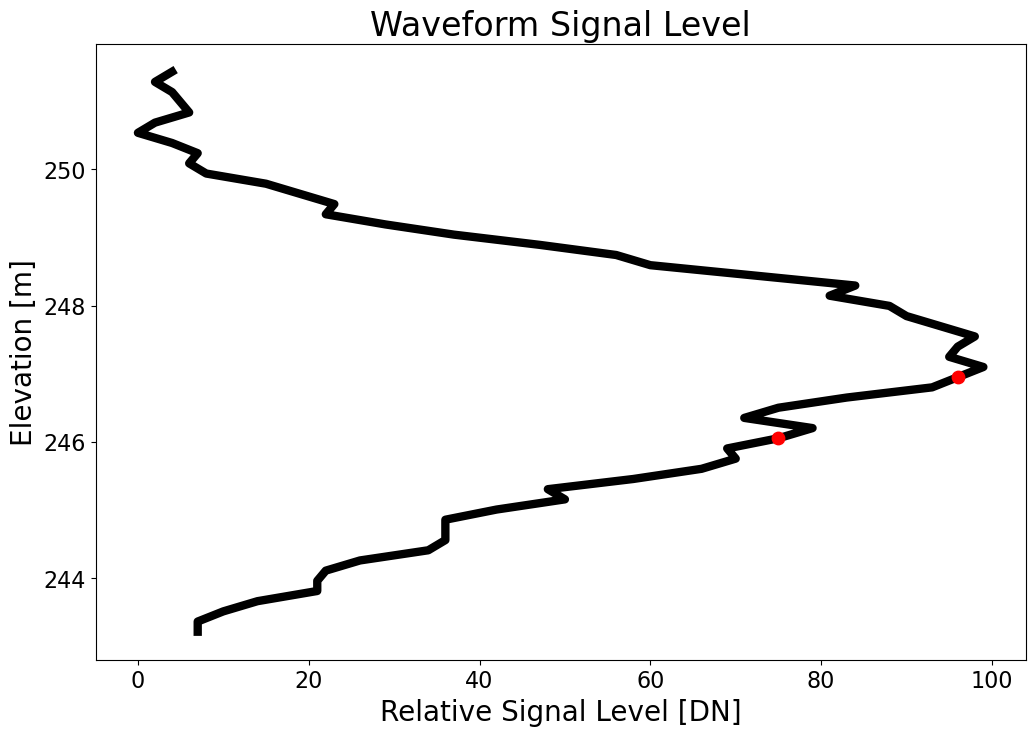

In [42]:
# Plot a few waveforms
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'
wvs_file = waveform_files[0] + '.wvs'
readbin_pls_file = open(pls_file,"rb")
readbin_pls_file.seek(0,0)
readbin_wvs_file = open(wvs_file,"rb")
readbin_wvs_file.seek(0,0)    

iPulse = 8379559

# dxdydz = dxdydz_array[iPulse,:]
# xyz_bin0 = xyz_bin0_array[iPulse,:]
# xyz_lastbin = xyz_lastbin_array[iPulse,:]
    
# Read waveform
waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
# print(waveform_z_axis)
print(np.mean(waveform_x_axis))
print(np.mean(waveform_y_axis))
# Evaluate waveform
#32.0
waveform_intensity_threshold = 10.0

# Peak location indices
return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)

print_waveform_location_information(waveform_x_axis, waveform_y_axis, waveform_z_axis, return_peak_location_list)
ax1.tick_params(axis='both',which='major',labelsize=16)
ax1.set_title('Waveform Signal Level', size = 24)
ax1.set_xlabel('Relative Signal Level [DN]', size = 20)
ax1.set_ylabel('Elevation [m]', size = 20)
ax1.plot(waveform,waveform_z_axis,color='black',linewidth=6,zorder=1)
ax1.scatter(return_intensity_list,waveform_z_axis[return_peak_location_list],color='red',s=80,zorder=2)

readbin_pls_file.close()
readbin_wvs_file.close()


In [43]:
def normalize_cumulative_return_energy(waveform_intensity_x, waveform_elevation_y, plot):
    # Create normalized cumulative signal energy from waveform intensity values
    cumulative_energy_RH_boundaries = [0.25, 0.5, 0.75, 1.0]
    
    # Turn elevation into relative height
    min_elevation = np.min(waveform_elevation_y)
    relative_elevations = waveform_elevation_y - min_elevation

    # Sort intensity by elevation
    combined_data = np.array(list(zip(relative_elevations, waveform_intensity_x)))
    sorted_data = combined_data[combined_data[:, 0].argsort()] 
    
    # Extract sorted intensity and elevation
    sorted_elevation = sorted_data[:, 0]
    sorted_intensity = sorted_data[:, 1]

    # Plot cumulative intensity
    cumulative_intensity_sum = np.cumsum(sorted_intensity)
    normalized_cumulative_intensity = cumulative_intensity_sum / cumulative_intensity_sum[-1]

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(normalized_cumulative_intensity, sorted_elevation, label="Normalized Cumulative Signal Level")
        RH_25_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[0])
        RH_50_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[1])
        RH_75_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[2])
        RH_100_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[3])
    
        # DN has no processing (raw lidar intensity)
        plt.xlabel("Normalized Cumulative Signal Level (DN)")
        plt.ylabel("Elevation (Feet)")
        plt.title("Normalized Cumulative Signal Level")
        plt.legend()
        plt.grid()
        plt.show()
    # print(f"25: {sorted_elevation[RH_25_index]}, 50: {sorted_elevation[RH_50_index]}, 75: {sorted_elevation[RH_75_index]}, 100: {sorted_elevation[RH_100_index]}")
    # Stack along the row to feed into KMeans with [normalized_cumulative_intensity1, sorted_elevation1, normalized_cumulative_intensity2, sorted_elevation1] 
    stacked_intensity_elevation = np.stack((normalized_cumulative_intensity, sorted_elevation), axis=1).ravel()
    return stacked_intensity_elevation

In [11]:
def interpolate_waveform_values(waveform, plot):
    # Input: 1d waveform array [norm_cum_signal_level1, elevation1...]
    # Interpolate values so that there is 20 total cumulative signal level values from 0, 0.025, 0.05 ... 1 
    # Needed because all waveform inputs into k-means must be the same size
    
    signal_raw_data = waveform[0::2]
    elevation_raw_data = waveform[1::2]

    # Connect the values together with straight lines (linear interpolate)
    connected_function = interp1d(signal_raw_data, elevation_raw_data, kind='linear', bounds_error=False, fill_value=(elevation_raw_data[0], elevation_raw_data[-1]))

    # Set normalized cumulative signal levels from 0-1 with 0.025 increments
    interpolated_signal_levels = np.linspace(0, 1, 41)
    interpolated_elevation_levels = connected_function(interpolated_signal_levels)

    # Handle 0 explicitly
    interpolated_elevation_levels[0] = 0.0

    if plot:
        plt.plot(signal_raw_data, elevation_raw_data, 'o', label='Original Data')        
        plt.plot(interpolated_signal_levels, interpolated_elevation_levels, '-', label='Interpolated Data')  
        plt.xlabel('Normalized Cumulative Signal Levels')
        plt.ylabel('Relative Elevation')
        plt.title('Interpolation')
        plt.legend()
        plt.grid()
        plt.show()
    
    interpolated_stacked_intensity_elevation = np.stack((interpolated_signal_levels, interpolated_elevation_levels), axis=1).ravel()
    # print(interpolated_stacked_intensity_elevation)
    return interpolated_stacked_intensity_elevation

In [12]:
def calculate_silhouette_score(kmeans_fitted, X_train, k):
    # Metric to find out best values of K and evaluate the model performance
    silhouette_avg = silhouette_score(X_train, kmeans_fitted.labels_)  
            
    print("K-value", k)
    print("Silhouette Score:", silhouette_avg)

In [13]:
def calculate_cumulative_signal_slopes(interpolated_waveforms, min_signal_level, max_signal_level):
    # Calculate slope of waveforms from min_signal_level to the max_signal_level and returns array with slopes of each waveform
    # Interpolated waveforms is a 1D array with signal, elevation
    waveform_slopes = []
    for waveform in interpolated_waveforms:
        signal_x = waveform[0::2]
        elevation_y = waveform[1::2]

        min_index = np.where(signal_x == min_signal_level)[0][0]
        max_index = np.where(signal_x == max_signal_level)[0][0]

        final_signal_x = signal_x[min_index:max_index+1]
        final_elevation_y = elevation_y[min_index:max_index+1]
        slope, intercept = np.polyfit(final_signal_x, final_elevation_y, 1)
        waveform_slopes.append(slope)
        
    return waveform_slopes

In [14]:
def check_normality(interpolated_waveforms, waveform):
    # See if relative elevation (y) is normally distributed for z-score outlier analysis

    if waveform:
        one_d_waveforms = interpolated_waveforms.flatten()
        elevation = one_d_waveforms[1::2]
        cum_signal_level = one_d_waveforms[0::2]
        
        plt.figure(figsize=(6, 6))
        stats.probplot(elevation, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Relative Elevation")
        plt.show()
    
        plt.figure(figsize=(6, 6))
        stats.probplot(cum_signal_level, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Signal Level")
        plt.show()
    else:
        plt.figure(figsize=(6, 6))
        stats.probplot(interpolated_waveforms, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Waveform Slopes")
        plt.show() 


In [15]:
def perform_normal_waveform_outlier_analysis(waveform_slopes):
    # Calculate Z-score analysis and identify outliers 2 z-scores away
    # Waveforms are population so ddof is 0
    z_score_threshold = 3
    z_scores = stats.zscore(waveform_slopes)
    
    outliers = np.where((z_scores > z_score_threshold) | (z_scores < -z_score_threshold))
    return outliers[0]

In [16]:
def calculate_neighbors_distances(interpolated_waveforms, k):
    # Calculate mean neighbors distance to determine epsilon values for DBSCAN clustering
    
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(interpolated_waveforms)
    distances, indices = neighbors_fit.kneighbors(interpolated_waveforms)

    distances = np.mean(distances[:,1:],axis=1)
    distances = np.sort(distances)
    plt.figure(figsize=(6,6))
    plt.title("Average Distance from a point to k-nearest neighbors")
    # Limit x values - different for every graph
    plt.xlim(14000, 16000)
    plt.plot(distances)

In [17]:
def calculate_dbscan_outlier_detection(interpolated_waveforms, min_pts, episilon):
    # Calculate DBSCAN to prune outliers on waveform data
    # min_pts depends on how many clusters in k-mean clustering/classes total
    dbscan = DBSCAN(eps=episilon, min_samples=min_pts)
    dbscan.fit(interpolated_waveforms)
    labels = dbscan.labels_

    # Outliers occur where the labels are -1
    outliers = np.where(labels == -1)[0]

    waveform_outliers = interpolated_waveforms[outliers]
    waveform_non_outliers = np.delete(interpolated_waveforms, outliers)
    print(waveform_outliers)
    plt.figure(figsize=(8,8))
    for waveform in waveform_non_outliers:
        plt.plot(waveform[0::2], waveform[1::2], c=labels)
    for waveform in waveform_outliers:
        plt.plot(waveform[0::2], waveform[1::2], c="red")
    plt.show()

In [18]:
def train_k_means_cluster_cumulative_returns(interpolated_waveforms_train, k_list, evaluate_elbow):
    # Different version of similar function that returns a trained k_means_cluster object for every k in the k-list
    k_means_classifiers = []
    sse = []
    for k in k_list:
        kmeans = KMeans(n_clusters=k, n_init="auto").fit(interpolated_waveforms_train) 
        k_means_classifiers.append(kmeans)
        sse.append(kmeans.inertia_)

        if evaluate_elbow:
            plt.plot(k_list, sse, '-o')

    if evaluate_elbow:
        plt.figure(figsize=(6, 6))
        plt.xlabel(r'Number of clusters k')
        plt.ylabel('Sum of squared distance')
        plt.show()
        
    return k_means_classifiers

In [19]:
def test_k_means_cluster_cumulative_returns(k_means_classifiers, X_test, k_list, plot_raw, evaluate_metrics):
    # K-means cluster waveforms based on trained classifiers and return cluster center waveform values and cluster assignments
    # Each is a 2D array with one dimension being the for each k_list and one for actual values
    cluster_centers = []
    test_cluster_assignments = []
    
    if plot_raw:
        plt.figure(figsize=(8, 6))
        for waveform in X_test:
            # Norm cumulativve energy is all even, relative elevation is all odd
            plt.plot(waveform[0::2], waveform[1::2])
            
        plt.xlabel("Normalized Cumulative Signal Level (DN)")
        plt.ylabel("Elevation (Feet)")
        plt.title("Raw Waveform Values")
        plt.grid()
        plt.show()
        
    for classifier in k_means_classifiers:
        test_cluster_assignments.append(classifier.predict(X_test))
        cluster_centers.append(classifier.cluster_centers_)
        
    if evaluate_metrics:
        for i, k in enumerate(k_list):
            # Calculate silhouette score: 1 is best, 0 means clusters are too close together, -1 means assigned to wrong cluster
            # Better for determining how many clusters are best and clustering at individual points
            silhouette_avg = silhouette_score(X_test, test_cluster_assignments[i])  
    
            # Calculate davies_bouldin_index: lower value indicates better clustering (good separation and compactness)
            # higher value suggests poor clustering (overlapping or poorly defined clusters)
            # Better for overall cluster comparisons
            db_index = davies_bouldin_score(X_test, test_cluster_assignments[i])
            print(f"K: {k} Silhouette Score: {silhouette_avg}, Davies Bouldin Score: {db_index}")
    
    return cluster_centers, test_cluster_assignments

In [20]:
def print_apparent_individual_biomass_information(apparent_individual_table, mapping_tagging_table, resolution, debug):
    # Print coordinates and total amount of apparent individuals in the plot based on plot resolution (1m, 3m, 10m, 25m, 50m, 100m)
    # Based on plot diagram found in NEON vegetation structure: https://data.neonscience.org/api/v0/documents/NEON_vegStructure_userGuide_vE?inline=true
    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)
    total_data_count = 0
    northing_arr = []
    easting_arr = []
    individual_id_arr = []
    
    for row in individual_df.itertuples(index=True, name="Row"):
        # Subplot resolution is always the 2nd number in subplotID
        subplot_resolution = row.subplotID.split("_")[1]
        stemDiameter = row.stemDiameter
        tagStatus = row.tagStatus
        indiv_id = row.individualID
        
        # Check if subplot meets certain criteria to determine geolocation
        if subplot_resolution.isdigit() and int(subplot_resolution) == resolution and not np.isnan(stemDiameter):
            northing = row.adjNorthing
            easting = row.adjEasting
            indiv_id = row.individualID
            
            northing_arr.append(northing)
            easting_arr.append(easting)
            individual_id_arr.append(indiv_id)
            total_data_count += 1
            if debug:
                print(f"Northing: {northing}, Easting: {easting}, ID: {indiv_id}")
            
        # Otherwise check if individual geolocation information is valid (tree is mapped)
        elif not np.isnan(stemDiameter) and row.individualID in mapping_df["individualID"].values:
            mapping_data = mapping_df.loc[mapping_df["individualID"] == indiv_id]
            northing = mapping_data["adjNorthing"].iloc[0]
            easting = mapping_data["adjEasting"].iloc[0]

            if not np.isnan(northing):
                northing_arr.append(northing)
                easting_arr.append(easting)
                individual_id_arr.append(indiv_id)
                total_data_count +=1
                if debug:
                    print(f"Northing: {northing}, Easting: {easting}, ID: {indiv_id}")
                    print("Mapped")
                
    print(f"Total individual data count: {total_data_count}")
    return np.array(northing_arr), np.array(easting_arr), np.array(individual_id_arr), total_data_count

In [21]:
def calculate_indv_tree_biomass(genus, family, species, dbh):
    # Lookup table for tree biomass based on DBH (cm) and genus, family, and species in Chojnacky paper
    # https://www.fs.usda.gov/nrs/pubs/jrnl/2014/nrs_2014_chojnacky_001.pdf
    # Some b0 and b1 are interpolated based on genus if species does not exist
    b0 = 0
    b1 = 0

    # 45 conifer species
    if genus == "Abies":
        if species == "balsamea" or species == "fraseri" or species == "lasiocarpa":
            # Abies < 0.35 spg
            b0 = -2.3123
            b1 = 2.3482
        else:
            # Abies >= 0.35 spg, intepolation for unknown species
            b0 = -3.1774
            b1 = 2.6426
    elif genus == "Thuja":
        if species == "occidentalis":
            # Cupressaceae < 0.30 spg
            b0 = -1.9615
            b1 = 2.1063
        elif species == "plicata":
            # Cupressaceae 0.3 - 0.39 spg
            b0 = -2.7765
            b1 = 2.4195
    elif genus == "Calocedrus" or genus == "Sequoiadendron":
        # Cupressaceae 0.3 - 0.39 spg
        b0 = -2.7765
        b1 = 2.4195  
    elif genus == "Chamaecyparis" or genus == "Juniperus":
        # Cupressaceae >= 0.4 spg
        b0 = -2.6327
        b1 = 2.4757
    elif genus == "Larix":
        # Larix
        b0 = -2.3012
        b1 = 2.3853
    elif genus == "Picea":
        if species == "engelmannii" or species == "sitchensis":
            # Picea < 0.35 spg
            b0 = -3.03
            b1 = 2.5567
        else:
            # Picea >= 0.35 spg, interpolation for unkown species
            b0 = -2.1364
            b1 = 2.3233
    elif genus == "Pinus":
        if species == "strobus" or species == "echinata" or species == "elliottii" or species == "palustris" or species == "rigida" or species == "taeda":
            # Pinus >= 0.45 spg
            b0 = -3.0506
            b1 = 2.6465
        else:
            # Pinus < 0.45 spg, interpolation for unknown species
            b0 = -2.6177
            b1 = 2.4638
    elif genus == "Pseudotsuga":
        # Pseudotsuga
        b0 = -2.4623
        b1 = 2.4852
    elif genus == "Tsuga":
        if species == "canadensis":
            # Tsuga < 0.4 spg
            b0 = -2.3480
            b1 = 2.3876
        elif species == "heterophylla" or species == "mertensiana":
            # Tsuga >= 0.4 spg
            b0 = -2.9208
            b1 = 2.5697
            
    # 70 hardwood species taxa, based on family
    elif family == "Aceraceae":
        if species == "saccharum":
            # Aceraceae >= 0.5 spg
            b0 = -1.8011
            b1 = 2.3852
        else:
            # Aceraceae < 0.5 spg, interpolation
            b0 = -2.0470
            b1 = 2.3852
    elif family == "Betulaceae":
        # No interpolation
        if genus == "Alnus":
            # Betulaceae < 0.4 spg
            b0 = -2.5932
            b1 = 2.5349
        elif species == "papyrifera" or species == "populifolia":
            # Betulaceae 0.4 - 0.49 spg
            b0 = -2.2271
            b1 = 2.4513
        elif species == "alleghaniensis":
            # Betulaceae 0.5 - 0.59
            b0 = -1.8096
            b1 = 2.3480
        elif species == "lenta" or genus == "Ostrya":
            # Betulaceae >= 0.6 spg
            b0 = -2.2652
            b1 = 2.5349
    elif family == "Cornaceae" or family == "Ericaceae" or family == "Lauraceae" or family == "Platanaceae" or family == "Rosaceae" or family == "Ulmaceae":
        b0 = -2.2118
        b1 = 2.4133
    elif family == "Juglandaceae":
        # Fabaceae/Juglandaceae Carya
        b0 = -2.5095
        b1 = 2.6175
    elif family == "Fabaceae":
        # Fabaceae other
        b0 = -2.5095
        b1 = 2.5437
    elif family == "Fagaceae":
        # Evergreen Fagaceae (e.g. Quercus chrysolepis, Q. laurifolia, Lithocarpus, etc.)
        evergreen_oaks = ["chrysolepis","densiflorus","douglasii","laurifolia","minima"]
        if species in evergreen_oaks:
            b0 = -2.2189
            b1 =  2.4410
        else:
            # Deciduous Fagaceae (e.g. Quercus alba, Q. rubra, etc., Castanea, Fagus)
            b0 = -2.0705
            b1 =  2.4410  
    elif family == "Hamamelidaceae":
        b0 = -2.6390
        b1 =  2.5466
    elif family in ["Hippocastanaceae", "Tiliaceae"]:
        b0 = -2.4108
        b1 =  2.1777
    elif family == "Magnoliaceae":
        b0 = -2.5497
        b1 =  2.5011
    elif family == "Oleaceae":
        if species == "americana":
            # Oleaceae >= 0.55 spg
            b0 = -1.8384
            b1 =  2.4950
        else:
            b0 = -2.0314
            b1 = 2.3524
    elif family == "Salicaceae":
        poplar_spg_map = {
            "balsamifera":   0.31,
            "trichocarpa":   0.31,
            "spp":           0.34, 
            "deltoides":     0.37,
            "grandidentata": 0.36,
            "tremuloides":   0.35
        }
        willow_spg_map = {
            "alba": 0.36,
            "spp":  0.36
        }

        if genus == "Populus":
            spg_val = poplar_spg_map.get(species, 0.34)
        elif genus == "Salix":
            spg_val = willow_spg_map.get(species, 0.36)
        else:
            spg_val = 0.36 

        if spg_val < 0.35:
            b0 = -2.6683
            b1 =  2.4561
        else:
            b0 = -2.4441
            b1 =  2.4291      
            
    # 15 Woodland species, uses drc instead of dbh
    elif family == "Cupressaceae":
        # e.g. Cupressus spp, Juniperus monosperma/occidentalis/osteosperma, etc.
        b0 = -2.7096
        b1 =  2.1942
    elif family in ["Fabaceae", "Rosaceae"]:
        # Fabaceae or Rosaceae group
        b0 = -2.9255
        b1 =  2.4109
    elif family == "Fagaceae":
        # Fagaceae group
        b0 = -3.0304
        b1 =  2.4982
    elif family == "Pinaceae":
        # Pinaceae group
        b0 = -3.2007
        b1 =  2.5339

    else:
        # The tree/shrub doesn't match any of the species
        print("Error: The tree/shrub doesn't match any of the species")
    return b0, b1

In [136]:
def calculate_total_tree_biomass(northing_area, easting_area, resolution, mapping_tagging_table, apparent_individual_table):

    biomass_data = []
    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)

    # Filter all mapping and tagging points to be within the northing area and easting area (bounding box)
    northing_range_max = northing_area + resolution/2
    northing_range_min = northing_area - resolution/2
    easting_range_max = easting_area + resolution/2
    easting_range_min = easting_area - resolution/2

    mapping_df_filtered = mapping_df[(mapping_df["adjNorthing"] >= northing_range_min) & (mapping_df["adjNorthing"] <= northing_range_max) 
                                    & (mapping_df["adjEasting"] >= easting_range_min) & (mapping_df["adjEasting"] <= easting_range_max)]
    
    not_found_count = 0
    lost_na_data_count = 0
    for row in mapping_df_filtered.itertuples(index=True, name="Row"):
        # Search mapping and tagging to get precise geolocation and species for individual table values
        if row.individualID in individual_df["individualID"].values:
            genus = row.genus
            family = row.family
            species = row.scientificName.split(" ")[1]

            # Get diameter breast height from individual table and check if tree is lost (no data)
            individual_data = individual_df.loc[individual_df["individualID"] == row.individualID]
            dbh = individual_data["stemDiameter"].iloc[0]
            measurement_height = individual_data["measurementHeight"].iloc[0]

            if np.isnan(dbh):
                lost_na_data_count += 1
                print("Tree data lost or invalid")
                continue

            if measurement_height < 130:
                print("DRC instead of DBH due to smaller tree size")
            b0, b1 = calculate_indv_tree_biomass(genus, family, species, dbh)

            # Based on Chojnacky 2013
            biomass_ln = b0 + b1 * np.log(dbh)
            raw_biomass = np.exp(biomass_ln)
            biomass_data.append(raw_biomass)
            print(b0, b1, dbh)
            
        else:
            not_found_count += 1
            print("Mapping and tagging not found in individual table")
    total_biomass = np.sum(biomass_data)
    print(biomass_data)
    # Todo: Potentially add geolocation data
    return total_biomass

In [131]:
def find_associated_biomass_waveform_pulse_number(biomass_northing_arr, biomass_easting_arr, waveform_x_axis, waveform_y_axis, shot_number, debug):
    # Check if pulse number is in between the 11 groups in slides
    
    # Find the shot/pulse number associated with each biomass point based on northing, easting, and its resolution 
    min_waveform_easting = np.min(waveform_x_axis)
    max_waveform_easting = np.max(waveform_x_axis)
    min_waveform_northing = np.min(waveform_y_axis)
    max_waveform_northing = np.max(waveform_y_axis)
    waveform_easting = np.mean([min_waveform_easting, max_waveform_easting])
    waveform_northing = np.mean([min_waveform_northing, max_waveform_northing])
    waveform_easting_min = waveform_easting - 0.5
    waveform_easting_max = waveform_easting + 0.5
    waveform_northing_min = waveform_northing - 0.5
    waveform_northing_max = waveform_northing + 0.5
    biomass_found = False

    # Stack biomass arrays for easier searching
    paired_biomass = np.column_stack((biomass_northing_arr, biomass_easting_arr))
    
    # Search paired biomass arrays for waveform
    biomass_index = np.where((paired_biomass[:, 0] >= waveform_northing_min) & (paired_biomass[:, 0] <= waveform_northing_max) & 
                             (paired_biomass[:,1] >= waveform_easting_min) & (paired_biomass[:, 1] <= waveform_easting_max))
    if biomass_index[0].size > 0:
        biomass_found = True
        if debug:
            print(f"Waveform biomass found at {paired_biomass[biomass_index[0]]}")
            print(f"Number of biomass values: {biomass_index[0].size}")

    return biomass_found, waveform_easting, waveform_northing

In [24]:
def find_associated_biomass_waveform_group(waveform_x_axis, waveform_y_axis, grouped_biomass, shot_number):
    # Check if waveform is within a biomass group
    biomass_found = False
    group_index = -2
    min_waveform_easting = np.min(waveform_x_axis)
    max_waveform_easting = np.max(waveform_x_axis)
    min_waveform_northing = np.min(waveform_y_axis)
    max_waveform_northing = np.max(waveform_y_axis)

    for index, group in enumerate(grouped_biomass):
        if min_waveform_easting >= group[0] and max_waveform_easting <= group[1] and min_waveform_northing >= group[2] and max_waveform_northing <= group[3]:
            biomass_found = True
            print(f"Waveform {shot_number} found in group {index + 1}")
    return biomass_found, group

In [113]:
def add_waveform_data_row_with_biomass(waveform_file_name, interp_waveforms, waveforms_x_axis, waveforms_y_axis, biomass_values, cluster_numbers, shot_numbers, biomass_group_number):
    waveform_elevation_data = interp_waveforms[1::2]
    waveform_intensity_data = interp_waveforms[0::2]

    # Have a seperate dataframe for actual waveform elevation data vs the metadata
    elevation_df = pd.DataFrame(waveform_elevation_data, columns=[f"Elevation_{waveform_intensity_data[i]}" for i in range(len(waveform_elevation_data))])

    waveform_biomass_df = pd.DataFrame({'FileName': waveform_file_name, 'Pulsenumber': shot_numbers, 'Biomass': biomass_values, 'Easting': waveforms_x_axis, 'Northing': waveforms_y_axis, 'Group': biomass_group_number, 'Cluster': cluster_numbers})
    waveform_biomass_df = pd.concat([waveform_biomass_df, elevation_df], axis=1)
    return waveform_biomass_df

In [87]:
def split_test_train_cluster_indices(cluster_group_values, number_of_clusters, clusters_with_no_data, split_percentage):
    # Split into train test for linear regression: 75%, 25% based on clusters
    
    train_indices_aggregate = []
    test_indices_aggregate = []
    
    # Build a dictionary of {cluster number: [associated indices in elevation data]}
    cluster_group_indices_train = {i: [] for i in range(number_of_clusters + 1)}
    cluster_group_indices_test = {i: [] for i in range(number_of_clusters + 1)}

    # Loop through each unique cluster
    unique_clusters = np.unique(cluster_group_values)
    for cluster in unique_clusters:
        if cluster in clusters_with_no_data:
            continue
            
        # Get indices for the current cluster group
        cluster_indices = np.where(cluster_group_values == cluster)[0]
        
        train_idx, test_idx = train_test_split(cluster_indices, test_size=split_percentage, random_state=0)
        
        # Add the indices to the respective lists
        train_indices_aggregate.extend(train_idx)
        test_indices_aggregate.extend(test_idx)
        cluster_group_indices_train[cluster].extend(train_idx)
        cluster_group_indices_test[cluster].extend(test_idx)

    return train_indices_aggregate, test_indices_aggregate, cluster_group_indices_train, cluster_group_indices_test

In [119]:
def perform_linear_regression_biomass(waveform_biomass_data_file):
    waveform_biomass_data = pd.read_csv(waveform_biomass_data_file)
    raw_waveform_data = waveform_biomass_data["WaveformData"]
    cluster_group_values = waveform_biomass_data["Cluster"].to_numpy()
    pulsenumbers = waveform_biomass_data["Pulsenumber"].to_numpy()
    biomass_values = np.array(waveform_biomass_data["Biomass"])
    split_percentage = 0.25
    
    # Waveform data is a string with all the arrays in the CSV, turn it into a 2D array of numbers
    processed_waveform_data = raw_waveform_data.apply(lambda x: np.array(x.replace("[", "").replace("]", "").split(), dtype=float))
    waveform_arrays = np.stack(processed_waveform_data.to_numpy())
    waveform_elevation_data = waveform_arrays[:, 1::2]
    
    # Get metrics
    mid_index = waveform_elevation_data.shape[1] // 2
    waveform_elevation_RH975 = waveform_elevation_data[:, [-2]]
    waveform_elevation_RH50 = waveform_elevation_data[:, [mid_index]]
    waveform_elevation_RH50_RH975 = waveform_elevation_data[:, [mid_index, -2]]

    # Cluster vars
    number_of_clusters = 10
    cluster_group_count = {i: 0 for i in range(number_of_clusters + 1)}
    cluster_regression_scores = {i: 0 for i in range(number_of_clusters + 1)}
    clusters_with_no_data = [3, 8, 10]

    # Get total amount of values in each cluster
    for cluster in cluster_group_values:
        cluster_group_count[cluster] += 1
        
    # print(cluster_group_count)
    # {0: 4, 1: 3, 2: 18, 3: 0, 4: 2, 5: 6, 6: 29, 7: 12, 8: 0, 9: 17, 10: 0}
    
    # Use the indices to create train and test splits for each array
    train_ind_aggr, test_ind_aggr, train_ind_cluster, test_ind_cluster = split_test_train_cluster_indices(cluster_group_values, number_of_clusters, clusters_with_no_data, split_percentage)
    elevation_waveform_train = waveform_elevation_RH50_RH975[train_ind_aggr]
    elevation_waveform_test = waveform_elevation_RH50_RH975[test_ind_aggr]
    
    cluster_train = cluster_group_values[train_ind_aggr]
    cluster_test = cluster_group_values[test_ind_aggr]
    
    pulsenumbers_train = pulsenumbers[train_ind_aggr]
    pulsenumbers_test = pulsenumbers[test_ind_aggr]
    
    biomass_train = biomass_values[train_ind_aggr]
    biomass_test = biomass_values[test_ind_aggr]

    # Fit one linear regression model with all waveforms
    regression_model = LinearRegression().fit(elevation_waveform_train, biomass_train)
    score = regression_model.score(elevation_waveform_test, biomass_test)
    print(f"Intercept: {regression_model.intercept_}")
    print(f"Coefficients: {regression_model.coef_}")
    print(f"Score: {score}")

    # Create a linear regression for all the clusters with all data as training
    for i in range(number_of_clusters + 1):
        if i in clusters_with_no_data:
            continue

        train_test_indices_aggregate = np.concatenate((train_ind_cluster[i], test_ind_cluster[i]))
        elevation_train_2 = waveform_elevation_RH50_RH975[train_ind_cluster[i]]
        elevation_test_2 = waveform_elevation_RH50_RH975[test_ind_cluster[i]]
        elevation_aggregate_2 = waveform_elevation_RH50_RH975[train_test_indices_aggregate]
            
        cluster_train_2 = cluster_group_values[train_ind_cluster[i]]
        cluster_test_2 = cluster_group_values[test_ind_cluster[i]]
        
        pulsenumbers_train_2 = pulsenumbers[train_ind_cluster[i]]
        pulsenumbers_test_2 = pulsenumbers[test_ind_cluster[i]]
        
        biomass_train_2 = biomass_values[train_ind_cluster[i]]
        biomass_test_2 = biomass_values[test_ind_cluster[i]]
        biomass_aggregate_2 = biomass_values[train_test_indices_aggregate]

        regression_model_2 = LinearRegression().fit(elevation_aggregate_2, biomass_aggregate_2)
        score_2 = regression_model_2.score(elevation_aggregate_2, biomass_aggregate_2)
        print(f"For cluster {i}")
        print(f"Intercept: {regression_model_2.intercept_}")
        print(f"Coefficients: {regression_model_2.coef_}")
        print(f"Score: {score_2}")
        print(biomass_test)
        print(pulsenumbers_test)

        # Plot scatter points used to create regression 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
        ax1.set_title(f'Waveform Relative Height 97.5 vs. Biomass Cluster {i}')
        ax1.set_xlabel('Relative Height (ft)')
        ax1.set_ylabel('Biomass (kg)')
        ax1.scatter(waveform_elevation_RH975[train_test_indices_aggregate], biomass_values[train_test_indices_aggregate])

        ax2.set_title(f'Waveform Relative Height 50 vs. Biomass Cluster {i}')
        ax2.set_xlabel('Relative Height (ft)')
        ax2.set_ylabel('Biomass (kg)')
        ax2.scatter(waveform_elevation_RH50[train_test_indices_aggregate], biomass_values[train_test_indices_aggregate])
        fig.tight_layout()
        plt.show()


Intercept: 466.2965736445996
Coefficients: [ 319.14258948 -157.12134212]
Score: 0.2419592947107112
For cluster 0
Intercept: 1568.1327105131757
Coefficients: [-978.66594618  328.32629907]
Score: 0.8958862359708198
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


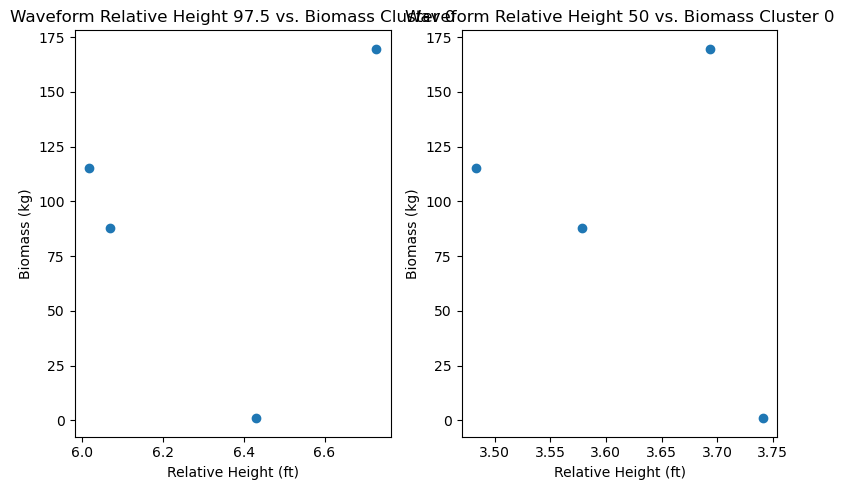

For cluster 1
Intercept: -5963.242911847505
Coefficients: [1045.70027353  923.88750024]
Score: 1.0
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


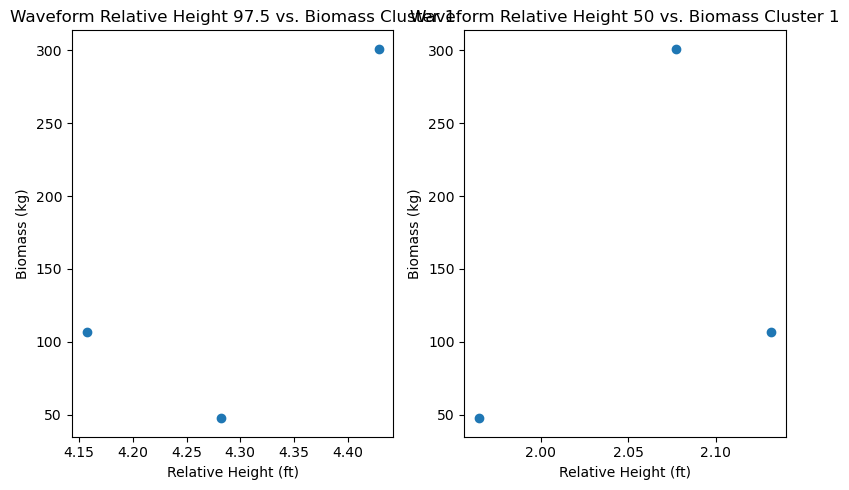

For cluster 2
Intercept: -924.4472518676556
Coefficients: [512.86915138  35.46979495]
Score: 0.004434366950653135
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


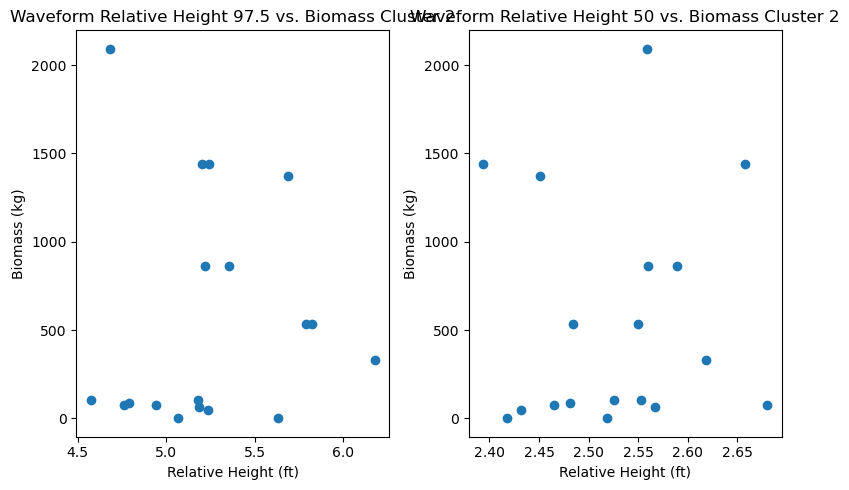

For cluster 4
Intercept: 2295.3140504461753
Coefficients: [0. 0.]
Score: 1.0
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


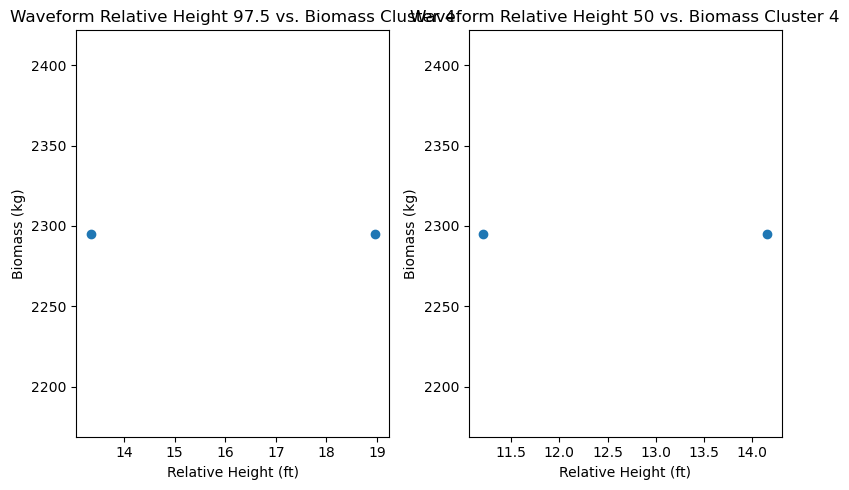

For cluster 5
Intercept: -12403.744193672208
Coefficients: [4891.35377385 -559.9520885 ]
Score: 0.9923423739118364
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


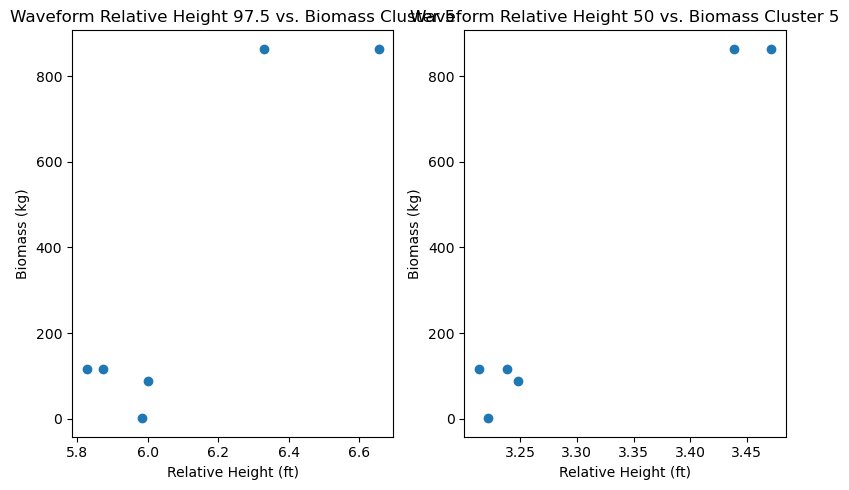

For cluster 6
Intercept: -1935.3667121723395
Coefficients: [154.34288026 330.82873766]
Score: 0.0323253448457449
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


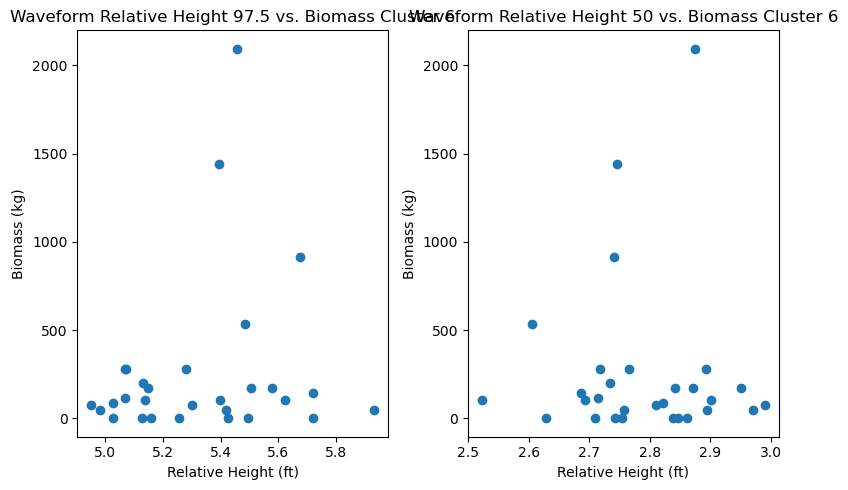

For cluster 7
Intercept: 20835.79051821076
Coefficients: [-7487.9311881    540.90121575]
Score: 0.5099708841685235
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


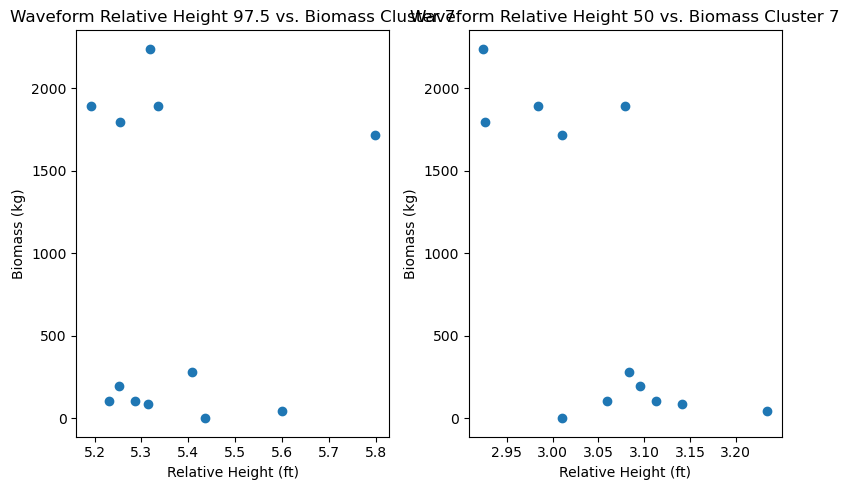

For cluster 9
Intercept: 4691.336559455178
Coefficients: [-433.86035807 -672.28794344]
Score: 0.09494243658863333
[8.76957600e+01 1.06517882e+02 8.63586451e+02 5.36290467e+02
 1.00000000e+00 7.77843815e+01 1.44288136e+03 2.29531405e+03
 8.76957600e+01 1.15324625e+02 1.00000000e+00 1.69683161e+02
 1.44288136e+03 1.00000000e+00 4.74672212e+01 2.82710519e+02
 2.82710519e+02 2.82710519e+02 2.82710519e+02 1.71862355e+03
 4.49186470e+01 9.94184462e+02 4.74672212e+01 1.00000000e+00
 1.02581210e+02 1.98940384e+02]
[8391879 4736688 8374098 8378305 8381331 8387125 8394343 8385141 8391878
 8373536 8371641 8393652 8394927 8382015 8380784 4719060 4719284 4719283
 4719061 4739557 8390064 8369827 8380785 8381340 8387685 4734525]


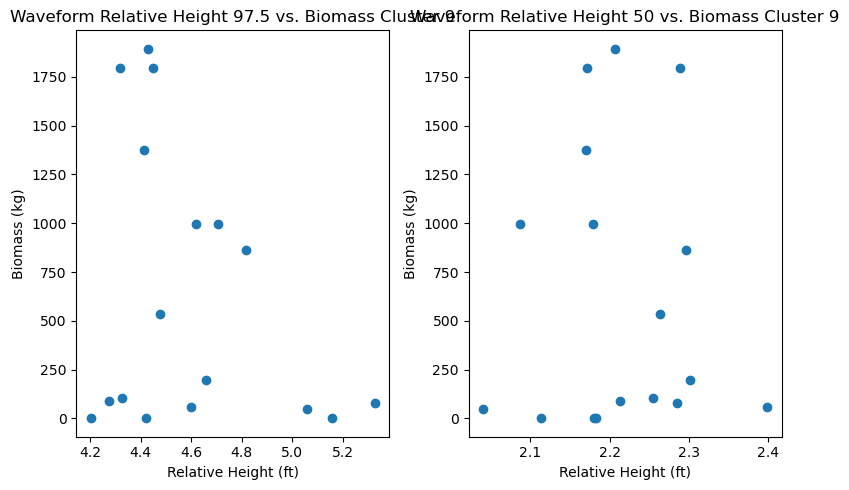

In [120]:
waveform_biomass_data_main_file = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main_group_4_6_aggregate.csv"
perform_linear_regression_biomass(waveform_biomass_data_main_file)

727085.735375
4704091.968874999
Ground return Easting 727085.47711, Northing: 4704092.01987
Max height return Easting 727085.99364, Northing: 4704092.01987
Peak location easting: [727085.66394 727085.51008], northing: [4704091.98298 4704092.01336]
Min easting value: 727085.47711, Max easting value: 727085.99364
Min northing value: 4704091.91788, Max northing value: 4704092.01987


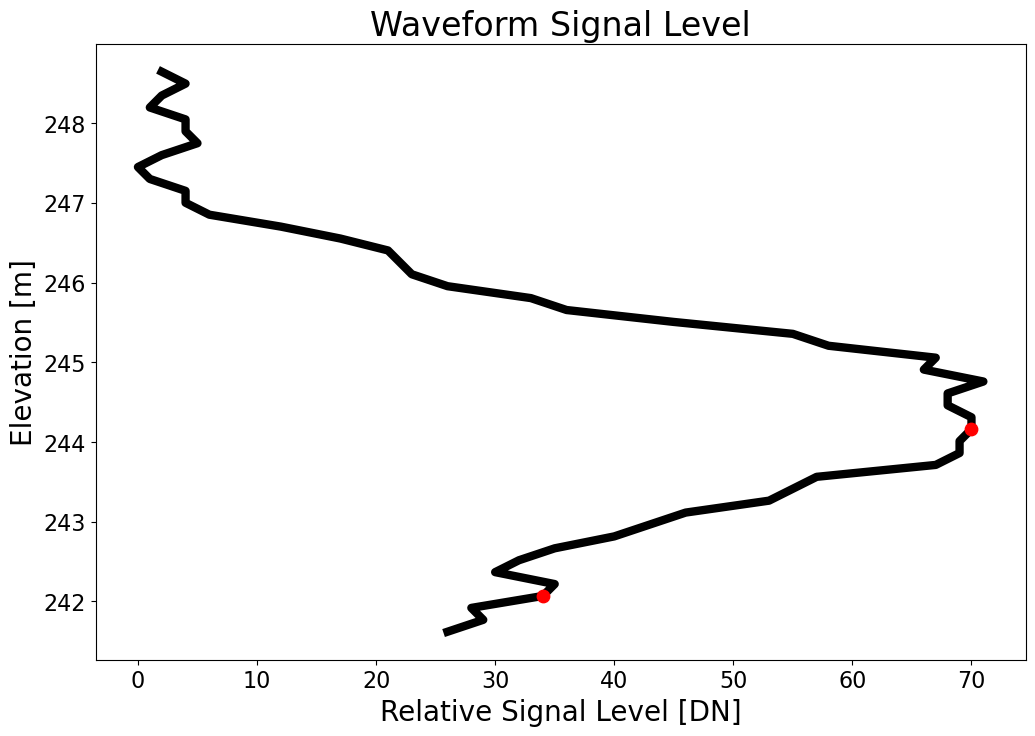

In [121]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'
wvs_file = waveform_files[0] + '.wvs'
readbin_pls_file = open(pls_file,"rb")
readbin_pls_file.seek(0,0)
readbin_wvs_file = open(wvs_file,"rb")
readbin_wvs_file.seek(0,0)    

iPulse = 8381331

# dxdydz = dxdydz_array[iPulse,:]
# xyz_bin0 = xyz_bin0_array[iPulse,:]
# xyz_lastbin = xyz_lastbin_array[iPulse,:]
    
# Read waveform
waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
# print(waveform_z_axis)
print(np.mean(waveform_x_axis))
print(np.mean(waveform_y_axis))
# Evaluate waveform
#32.0
waveform_intensity_threshold = 10.0

# Peak location indices
return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)

print_waveform_location_information(waveform_x_axis, waveform_y_axis, waveform_z_axis, return_peak_location_list)
ax1.tick_params(axis='both',which='major',labelsize=16)
ax1.set_title('Waveform Signal Level', size = 24)
ax1.set_xlabel('Relative Signal Level [DN]', size = 20)
ax1.set_ylabel('Elevation [m]', size = 20)
ax1.plot(waveform,waveform_z_axis,color='black',linewidth=6,zorder=1)
ax1.scatter(return_intensity_list,waveform_z_axis[return_peak_location_list],color='red',s=80,zorder=2)

readbin_pls_file.close()
readbin_wvs_file.close()

In [137]:
mapping_tagging_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
apparent_individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"
calculate_total_tree_biomass(4704091, 727085, 2, mapping_tagging_table, apparent_individual_table)

-2.2652 2.5349 23.6
[313.63951667049747]


313.63951667049747

In [116]:
def cumulative_waveform_analysis_main():
    # Reading files vars
    waveform_files = waveform_file.split('.')
    pls_file = waveform_files[0] + '.pls'
    wvs_file = waveform_files[0] + '.wvs'
    readbin_pls_file = open(pls_file,"rb")
    readbin_pls_file.seek(0,0)
    readbin_wvs_file = open(wvs_file,"rb")
    readbin_wvs_file.seek(0,0)
    waveform_file_name = waveform_file.split("_")[4]
    
    # Easting, northing, and resolution vars
    min_easting_range = float('inf')
    max_easting_range = float('-inf')
    min_northing_range = float('inf')
    max_northing_range = float('-inf')
    distances_between_waveform_easting = []
    distances_between_waveform_northing = []
    avg_waveform_distance_easting = 0
    avg_waveform_distance_northing = 0
    waveform_easting_values = []
    waveform_northing_values = []
    # waveform_numbers = []
    
    waveform_cum_energy = []
    original_waveforms_intensity = []
    original_waveforms_elevation = []
    total_num_multiple_segments = 0
    waveform_start_index = 8500000
    waveform_finish_index = 9000000
    # waveform_finish_index = 6500000
    prev_waveform_easting = 0
    prev_waveform_northing = 0

    # Biomass vars
    mapping_tagging_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
    apparent_individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"
    biomass_northing = 4707722.0
    biomass_easting = 723944.0
    resolution = 1
    count = 0
    shot_numbers_with_existing_biomass = []
    # biomass_waveform_northing = []
    # biomass_waveform_easting = []
    waveform_easting_biomass_found = []
    waveform_northing_biomass_found = []
    total_biomass_nums = []

    # Biomass geolocation groups: Easting min, easting max, northing min, northing max
    group_1_geolocation = [732106, 732147, 4713825, 4713844]
    group_2_geolocation = [723926, 723944, 4707713, 4707732]
    group_3_geolocation = [727586, 727605, 4704386, 4704405]
    group_4_geolocation = [727077, 727097, 4704083, 4704104]
    group_5_geolocation = [728124, 728143, 4702855, 4702877]
    group_6_geolocation = [727049, 727066, 4701145, 4701163]
    group_7_geolocation = [727884, 727902, 4700908, 4700925]
    group_8_geolocation = [725546, 725566, 4700513, 4700534]
    group_9_geolocation = [726500, 726521, 4699044, 4699063]
    group_10_geolocation = [725997, 726016, 4698177, 4698195]
    group_11_geolocation = [725964, 725986, 4696973, 4696994]
    all_grouped_biomass_locations = np.array([group_1_geolocation,
                                    group_2_geolocation,
                                    group_3_geolocation,
                                    group_4_geolocation,
                                    group_5_geolocation,
                                    group_6_geolocation,
                                    group_7_geolocation,
                                    group_8_geolocation,
                                    group_9_geolocation,
                                    group_10_geolocation,
                                    group_11_geolocation])

    # Save biomass geolocation into csv
    # biomass_df = pd.DataFrame({'Easting': biomass_easting_arr, 'Northing': biomass_northing_arr})
    # biomass_df.to_csv("valid_biomass_geolocation_info.csv", index=False)
    # Save waveform data into main csv file
    waveform_elevation_axis_numbers = np.arange(0, 100.1, 2.5)
    columns = ['FileName', 'Pulsenumber', 'WaveformData', 'Biomass', 'Easting', 'Northing', 'Group', 'Cluster'] + [f"Elevation_{i}" for i in waveform_elevation_axis_numbers]
    
    biomass_waveform_df = pd.DataFrame(columns=columns)
    
    start_t = time.time()
    # Get biomass geolocation information
    biomass_northing_arr, biomass_easting_arr, biomass_id_arr, biomass_count = print_apparent_individual_biomass_information(apparent_individual_table, mapping_tagging_table, resolution, False)

    waveform_start_index_copy = waveform_start_index
    while waveform_start_index <= waveform_finish_index:
        # Read waveform
        waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,waveform_start_index,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
        cur_waveform_avg_easting = np.mean(waveform_x_axis)
        cur_waveform_avg_northing = np.mean(waveform_y_axis)

        if multiple_segments_bool:
            total_num_multiple_segments += 1

        # Calculate distance between waveform for resolution
        if count != 0:
            distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
            distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
            distances_between_waveform_easting.append(distance_between_waveform_easting)
            distances_between_waveform_northing.append(distance_between_waveform_northing)

        waveform_min_easting = waveform_x_axis.min()
        waveform_max_easting = waveform_x_axis.max()
        waveform_min_northing = waveform_y_axis.min()
        waveform_max_northing = waveform_y_axis.max()
        indv_waveform_easting_geolocation = np.mean([waveform_min_easting, waveform_max_easting])
        indv_waveform_northing_geolocation = np.mean([waveform_min_northing, waveform_max_northing])
        # waveform_easting_values.append(indv_waveform_easting_geolocation)
        # waveform_northing_values.append(indv_waveform_northing_geolocation)
        # waveform_numbers.append(waveform_start_index)
        
        min_easting_range = min(min_easting_range, waveform_min_easting)
        max_easting_range = max(max_easting_range, waveform_max_easting)
        min_northing_range = min(min_northing_range, waveform_min_northing)
        max_northing_range = max(max_northing_range, waveform_max_northing)
        
        # Evaluate waveform
        waveform_intensity_threshold = 20.0
        
        # Peak location indices
        # return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)
        waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
        original_waveforms_intensity.append(waveform)
        original_waveforms_elevation.append(waveform_z_axis)
        
        # Interesting observation: length is either 80, 96, 112, or 240 (multiple segments in 240) so 40, 48, 56, or 120 values
        waveform_cum_energy.append(waveform_energy_elev_arr)

        # See if waveform biomass exists
        biomass_group_found, biomass_group_number = find_associated_biomass_waveform_group(waveform_x_axis, waveform_y_axis, all_grouped_biomass_locations, waveform_start_index)
        # biomass_found, biomass_waveform_easting, biomass_waveform_northing = find_associated_biomass_waveform_pulse_number(biomass_northing_arr, biomass_easting_arr, waveform_x_axis, waveform_y_axis, waveform_start_index, False)
        # if biomass_found:
        #     shot_numbers_with_existing_biomass.append(waveform_start_index)
        #     waveform_easting_biomass_found.append(biomass_waveform_easting)
        #     waveform_northing_biomass_found.append(biomass_waveform_northing)
        #     waveform_easting_values.append(indv_waveform_easting_geolocation)
        #     waveform_northing_values.append(indv_waveform_northing_geolocation)

        #     # This is for a variable resolution (smaller). For now keep it at 1m
        #     # waveform_resolution = max(waveform_max_easting - waveform_min_easting, waveform_max_northing - waveform_min_northing)
        #     # print(waveform_resolution)
        #     waveform_resolution = 1
        #     biomass_num = calculate_total_tree_biomass(indv_waveform_northing_geolocation, indv_waveform_easting_geolocation, waveform_resolution, mapping_tagging_table, apparent_individual_table)

        #     if biomass_num == 0.0:
        #         print(f"No biomass found for waveform {waveform_start_index}")
        #     total_biomass_nums.append(biomass_num)
            
        #     # Interpolate waveform data for RH metrics
        #     # Comment these underneath if not building main data table
        #     interpolated_wf = interpolate_waveform_values(waveform_energy_elev_arr, False)
        # new_biomass_row = add_waveform_data_row_with_biomass(waveform_file_name, waveform_energy_elev_arr, waveform_x_axis, waveform_y_axis, biomass_num, 0, waveform_start_index, biomass_group_number):
        #     # Add information to main dataframe
        #   biomass_waveform_df = pd.concat([biomass_waveform_df, new_row_df], ignore_index=True)
            
        prev_waveform_easting = cur_waveform_avg_easting
        prev_waveform_northing = cur_waveform_avg_northing
        waveform_start_index += 1
        count += 1
    end_t = time.time()
    
    print(f"Processing biomass times: {end_t - start_t}")
    # print(shot_numbers_with_existing_biomass)
    print(total_biomass_nums)
    # Save geolocation of waveforms
    # waveform_location_df = pd.DataFrame({'Pulsenumber': waveform_numbers, 'Easting': waveform_easting_values, 'Northing': waveform_northing_values})
    # waveform_location_df.to_csv("waveform_geolocation_info.csv", index=False)
    
    # Save main biomass waveform data - CHANGE NAME FOR EACH GROUP
    # print(biomass_waveform_df.dtypes)
    # biomass_waveform_df.to_csv("biomass_waveform_data_main_group_4.csv", index=False)

    
    # Range of all the waveforms
    print(f"Easting range: {min_easting_range} to {max_easting_range}")
    print(f"Northing range: {min_northing_range} to {max_northing_range}")
    print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
    print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
    print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
    print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")


    # Interpolate all waveforms to the same size
    # interpolated_waveforms = []
    # for waveform in waveform_cum_energy:
    #     interpolated_wf_one = interpolate_waveform_values(waveform, False)
    #     interpolated_waveforms.append(interpolated_wf_one)
    # interpolated_waveforms = np.array(interpolated_waveforms)


    # Interpolate the waveforms of biomass waveforms
    
    # Calculate slopes of signal vs. relative elevation to perform outlier detection
    # waveform_0_25_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.0, 0.25)
    # waveform_25_50_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.25, 0.5)
    # waveform_50_75_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.5, 0.75)
    # waveform_75_100_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.75, 1.0)
    
    # check_normality(waveform_0_25_slopes, False)
    # check_normality(waveform_25_50_slopes, False)
    # check_normality(waveform_50_75_slopes, False)
    # check_normality(waveform_75_100_slopes, False)

    # outlier_0_25 = perform_normal_waveform_outlier_analysis(waveform_0_25_slopes)
    # outlier_25_50 = perform_normal_waveform_outlier_analysis(waveform_25_50_slopes)
    # outlier_50_75 = perform_normal_waveform_outlier_analysis(waveform_50_75_slopes)
    # outlier_75_100 = perform_normal_waveform_outlier_analysis(waveform_75_100_slopes)

    # outliers_aggregated = np.unique(np.concatenate([outlier_0_25, outlier_25_50, outlier_50_75, outlier_75_100]))
    # waveform_outliers = interpolated_waveforms[outliers_aggregated]
    # print(len(waveform_outliers))
    # print(total_num_multiple_segments)

    # filtered_waveforms = np.delete(interpolated_waveforms, outliers_aggregated, axis=0)
    
    # print(f"Northing Min: {np.min(biomass_northing_arr)}")
    # print(f"Northing Max: {np.max(biomass_northing_arr)}")
    # print(f"Easting Min: {np.min(biomass_easting_arr)}")
    # print(f"Easting Max: {np.max(biomass_easting_arr)}")
    
    # biomass = calculate_total_tree_biomass(biomass_northing, biomass_easting, resolution, mapping_tagging_table, apparent_individual_table)
    # print(biomass)
    # Plot outliers with all waveforms
    # plt.figure(figsize=(12,8))
    # plt.title("Waveform Outliers")
    # plt.xlabel("Normalized Cumulative Signal Level")
    # plt.ylabel("Relative Elevation (Feet)")

    # for waveform in waveform_outliers:
    #     plt.plot(waveform[0::2], waveform[1::2], color='red')
    # for waveform in filtered_waveforms:
    #     plt.plot(waveform[0::2], waveform[1::2], color='lightgray')
    # plt.show()

    # Plot outlier's original waveform    
    # plotting_waveform_index = 100
    # waveform_example = interpolated_waveforms[outliers_aggregated[plotting_waveform_index]]
    # original_waveform_elevation = original_waveforms_elevation[outliers_aggregated[plotting_waveform_index]]
    # original_waveform_intensity = original_waveforms_intensity[outliers_aggregated[plotting_waveform_index]]

    # fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    # ax1.set_title("Cumulative Signal Return Level Outlier")
    # ax1.set_xlabel("Normalized Cumulative Signal Level")
    # ax1.set_ylabel("Relative Elevation (Feet)")
    # ax1.plot(waveform_example[0::2], waveform_example[1::2])

    # ax2.set_title("Original Waveform Plot")
    # ax2.set_xlabel("Signal Level")
    # ax2.set_ylabel("Elevation")
    # ax2.plot(original_waveform_intensity, original_waveform_elevation)
    
    # plt.tight_layout()
    # plt.show()

    # for waveform in waveform_outliers:
    #     plt.plot(waveform[0::2], waveform[1::2], color='red')
    # for waveform in filtered_waveforms:
    #     plt.plot(waveform[0::2], waveform[1::2], color='lightgray')
    # plt.show()

In [50]:
cumulative_waveform_analysis_main()
# Group 8: 3,592,888 - 3615790
# Northing range: 4703619.0978 to 4704008.779499999
# Easting range: 726059.4086200006 to 726883.37525
# Northing range: 4695707.48043 to 4696663.511
# 500,000 - 100,000
# Easting range: 726133.0999 to 726957.2770600003
# Northing range: 4696646.919969996 to 4697159.7633500025
# Easting range: 725952.2486900002 to 726725.9793199999

Total individual data count: 279
Processing biomass times: 144.48762798309326
[]
Easting range: 726763.5850099996 to 727521.33981
Northing range: 4704174.113050005 to 4704617.036520001
Average easting resolution between waveforms: 1.2478881680701068
Average northing resolution between waveforms: 0.018662515472084282
Max easting resolution between waveforms: 43.36310000042431
Max northing resolution between waveforms: 0.5959800006821752


Easting range: 727184.7564100001 to 727817.2758000003
Northing range: 4695772.836099997 to 4695922.408810002
Average easting resolution between waveforms: 727534.5356584827
Average northing resolution between waveforms: 4695851.205768456
Max easting resolution between waveforms: 727816.3655400004
Max northing resolution between waveforms: 4695922.348945002
Easting range: 726897.3661499998 to 727817.2758000003
Northing range: 4695772.836099997 to 4701240.329450003
Average easting resolution between waveforms: 727391.938284242
Average northing resolution between waveforms: 4698513.881281692
Max easting resolution between waveforms: 727816.3655400004
Max northing resolution between waveforms: 4701240.325745003
Easting range: 726690.4858100002 to 727817.2758000003
Northing range: 4695772.836099997 to 4709213.555990001
Average easting resolution between waveforms: 727269.5851026839
Average northing resolution between waveforms: 4702061.649889192
Max easting resolution between waveforms: 727

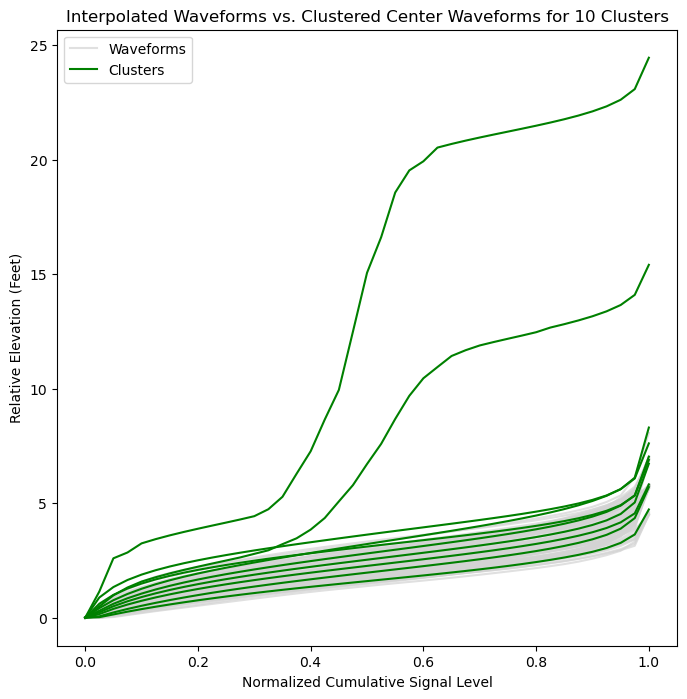

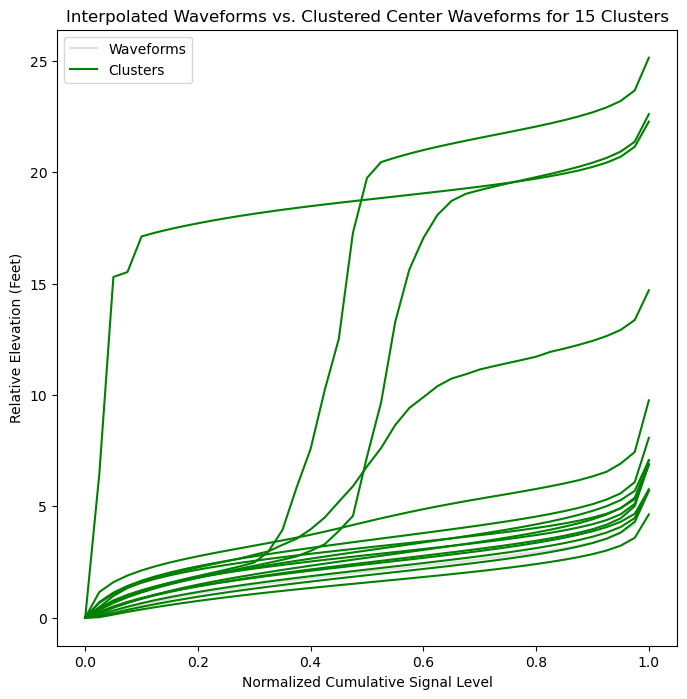

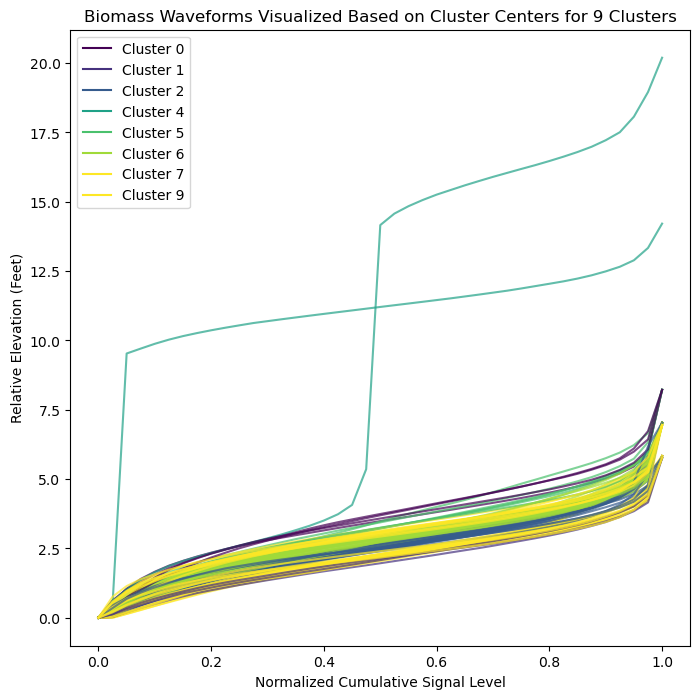

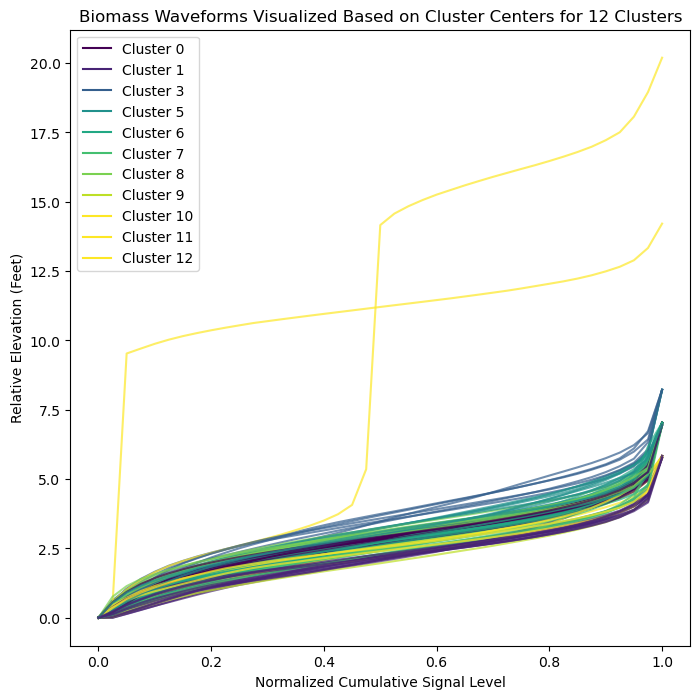

Total processing time: 79.54853796958923


In [38]:
# K_means_cluster execution and setup
# 300,000 total waveforms from different areas in the file
waveform_start_1 = 0
waveform_end_1 = 100000
waveform_start_2 = 4700000
waveform_end_2 = 4800000
waveform_start_3 = 15000000
waveform_end_3 = 15100000

waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'
wvs_file = waveform_files[0] + '.wvs'
readbin_pls_file = open(pls_file,"rb")
readbin_pls_file.seek(0,0)
readbin_wvs_file = open(wvs_file,"rb")
readbin_wvs_file.seek(0,0)

# Easting, northing, and resolution vars
min_easting_range = float('inf')
max_easting_range = float('-inf')
min_northing_range = float('inf')
max_northing_range = float('-inf')
distances_between_waveform_easting = []
distances_between_waveform_northing = []
avg_waveform_distance_easting = 0
avg_waveform_distance_northing = 0
prev_waveform_easting = 0
prev_waveform_northing = 0

k_list = [10, 15]
waveform_cum_energy = []
total_num_multiple_segments = 0
count = 0

biomass_waveforms_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main_group_4_6_aggregate.csv")
shot_numbers_with_biomass = biomass_waveforms_df["Pulsenumber"].to_numpy()

start = time.time()

waveform_start_index_copy = waveform_start_1
while waveform_start_1 <= waveform_end_1:
    # Read waveform
    waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,waveform_start_1,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
    cur_waveform_avg_easting = np.mean(waveform_x_axis)
    cur_waveform_avg_northing = np.mean(waveform_y_axis)

    if multiple_segments_bool:
        total_num_multiple_segments += 1

    # Calculate distance between waveform for resolution
    if count != 0:
        distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
        distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
        distances_between_waveform_easting.append(distance_between_waveform_easting)
        distances_between_waveform_northing.append(distance_between_waveform_northing)

    waveform_min_easting = waveform_x_axis.min()
    waveform_max_easting = waveform_x_axis.max()
    waveform_min_northing = waveform_y_axis.min()
    waveform_max_northing = waveform_y_axis.max()
    
    min_easting_range = min(min_easting_range, waveform_min_easting)
    max_easting_range = max(max_easting_range, waveform_max_easting)
    min_northing_range = min(min_northing_range, waveform_min_northing)
    max_northing_range = max(max_northing_range, waveform_max_northing)
    
    waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
    
    # Interesting observation: length is either 80, 96, 112, or 240 (multiple segments in 240) so 40, 48, 56, or 120 values
    waveform_cum_energy.append(waveform_energy_elev_arr)
    waveform_start_1 += 1
    count += 1
    
print(f"Easting range: {min_easting_range} to {max_easting_range}")
print(f"Northing range: {min_northing_range} to {max_northing_range}")
print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")

count = 0
while waveform_start_2 <= waveform_end_2:
    # Read waveform
    waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,waveform_start_2,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
    cur_waveform_avg_easting = np.mean(waveform_x_axis)
    cur_waveform_avg_northing = np.mean(waveform_y_axis)

    if multiple_segments_bool:
        total_num_multiple_segments += 1

    # Calculate distance between waveform for resolution
    if count != 0:
        distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
        distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
        distances_between_waveform_easting.append(distance_between_waveform_easting)
        distances_between_waveform_northing.append(distance_between_waveform_northing)

    waveform_min_easting = waveform_x_axis.min()
    waveform_max_easting = waveform_x_axis.max()
    waveform_min_northing = waveform_y_axis.min()
    waveform_max_northing = waveform_y_axis.max()
    
    min_easting_range = min(min_easting_range, waveform_min_easting)
    max_easting_range = max(max_easting_range, waveform_max_easting)
    min_northing_range = min(min_northing_range, waveform_min_northing)
    max_northing_range = max(max_northing_range, waveform_max_northing)
    
    waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
    
    # Interesting observation: length is either 80, 96, 112, or 240 (multiple segments in 240) so 40, 48, 56, or 120 values
    waveform_cum_energy.append(waveform_energy_elev_arr)
    waveform_start_2 += 1
    count += 1
    
print(f"Easting range: {min_easting_range} to {max_easting_range}")
print(f"Northing range: {min_northing_range} to {max_northing_range}")
print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")

count = 0
while waveform_start_3 <= waveform_end_3:
    # Read waveform
    waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,waveform_start_3,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
    cur_waveform_avg_easting = np.mean(waveform_x_axis)
    cur_waveform_avg_northing = np.mean(waveform_y_axis)

    if multiple_segments_bool:
        total_num_multiple_segments += 1

    # Calculate distance between waveform for resolution
    if count != 0:
        distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
        distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
        distances_between_waveform_easting.append(distance_between_waveform_easting)
        distances_between_waveform_northing.append(distance_between_waveform_northing)

    waveform_min_easting = waveform_x_axis.min()
    waveform_max_easting = waveform_x_axis.max()
    waveform_min_northing = waveform_y_axis.min()
    waveform_max_northing = waveform_y_axis.max()
    
    min_easting_range = min(min_easting_range, waveform_min_easting)
    max_easting_range = max(max_easting_range, waveform_max_easting)
    min_northing_range = min(min_northing_range, waveform_min_northing)
    max_northing_range = max(max_northing_range, waveform_max_northing)
    
    waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
    
    # Interesting observation: length is either 80, 96, 112, or 240 (multiple segments in 240) so 40, 48, 56, or 120 values
    waveform_cum_energy.append(waveform_energy_elev_arr)
    waveform_start_3 += 1
    count += 1
    
print(f"Easting range: {min_easting_range} to {max_easting_range}")
print(f"Northing range: {min_northing_range} to {max_northing_range}")
print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")

interpolated_waveforms = []
for waveform in waveform_cum_energy:
    interpolated_wf_one = interpolate_waveform_values(waveform, False)
    interpolated_waveforms.append(interpolated_wf_one)
interpolated_waveforms = np.array(interpolated_waveforms)

# Get test data: interpolated waveforms of only the shot numbers that have biomass
biomass_waveforms_interpolated = []
for pulsenumber in shot_numbers_with_biomass:
    waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,pulsenumber,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
    waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
    interpolated_wf_one = interpolate_waveform_values(waveform_energy_elev_arr, False)
    biomass_waveforms_interpolated.append(interpolated_wf_one)
biomass_waveforms_interpolated = np.array(biomass_waveforms_interpolated)

k_means_classifiers = train_k_means_cluster_cumulative_returns(interpolated_waveforms, k_list, False)
cluster_centers, cluster_assignments = test_k_means_cluster_cumulative_returns(k_means_classifiers, biomass_waveforms_interpolated, k_list, False, True)

# Plot results 
# Plot cluster centers vs full raw data for each k value
count = 0
for i, cluster_group in enumerate(cluster_centers):
    plt.figure(figsize=(8,8))
    
    for waveform in interpolated_waveforms:
        plt.plot(waveform[0::2], waveform[1::2], color='lightgray', alpha=0.7)
        count += 1
        if count > 100:
            break

    for cluster in cluster_group:
        clustered_signal_levels = cluster[0::2]
        clustered_elevation = cluster[1::2]
        plt.plot(clustered_signal_levels, clustered_elevation, color='green')
    
    plt.title(f"Interpolated Waveforms vs. Clustered Center Waveforms for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (Feet)")
    waveform_legend = mlines.Line2D([], [], color='lightgray', alpha=0.7, label='Waveforms')
    cluster_legend = mlines.Line2D([], [], color='green', label='Clusters')
    plt.legend(handles=[waveform_legend, cluster_legend])
    plt.show()

# Plot cluster centers vs test data for each k value, highlighted by which cluster they belong to 
for i, cluster_assignment in enumerate(cluster_assignments):
    unique_clusters = np.unique(cluster_assignment)
    # Create a colormap with as many colors as there are clusters.
    colors = plt.get_cmap('viridis', len(unique_clusters))
    
    plt.figure(figsize=(8,8))
    # Plot each waveform with its corresponding cluster color.
    for waveform, cluster in zip(biomass_waveforms_interpolated, cluster_assignment):
        plt.plot(waveform[0::2], waveform[1::2], color=colors(cluster), alpha=0.7)
    
    # Create legend handles for each cluster color.
    cluster_handles = []
    for cluster in unique_clusters:
        handle = mlines.Line2D([], [], color=colors(cluster), label=f'Cluster {cluster}')
        cluster_handles.append(handle)
    
    plt.title(f"Biomass Waveforms Visualized Based on Cluster Centers for {cluster} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (Feet)")
    plt.legend(handles=cluster_handles)
    plt.show()

# Save cluster assignments
columns = ['Pulsenumber', 'Cluster']

cluster_assignments_df_10 = pd.DataFrame(columns=columns)
cluster_assignments_df_10 = cluster_assignments_df_10.astype({
                            'Pulsenumber': 'int64','Cluster': 'int32'})
cluster_assignments_df_15 = cluster_assignments_df_10.copy()

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[0][i]
    }
    cluster_assignments_df_10.loc[len(cluster_assignments_df_10)] = new_cluster_row

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[1][i]
    }
    cluster_assignments_df_15.loc[len(cluster_assignments_df_15)] = new_cluster_row
cluster_assignments_df_10.to_csv("waveform_biomass_cluster_assignments_k_10", index=False)
cluster_assignments_df_15.to_csv("waveform_biomass_cluster_assignments_k_15", index=False)

end = time.time()
print(f"Total processing time: {end-start}")

In [35]:
start = time.time()
k = 4
processed_waveforms, cluster_centers = k_means_cluster_cumulative_returns(0, 100, [k], False, False, True)

# Plot clusters and raw data together
clustered_signal_level = cluster_centers[0][0::2]
clustered_elevation = cluster_centers[0][1::2]

plt.figure(figsize=(8, 8))
for waveform in processed_waveforms:
    plt.plot(waveform[0::2], waveform[1::2], color='lightgray', alpha=0.7)
for cluster in cluster_centers[0]:
    plt.plot(cluster[0::2], cluster[1::2], color='green')

waveform_legend = mlines.Line2D([], [], color='lightgray', alpha=0.7, label='Waveforms')
cluster_legend = mlines.Line2D([], [], color='green', label='Clusters')

plt.title("Interpolated Waveforms vs. Clustered Waveforms")
plt.xlabel("Normalized Cumulative Signal Level")
plt.ylabel("Relative Elevation (Feet)")
plt.legend(handles=[waveform_legend, cluster_legend])
plt.show()

end = time.time()
print(f"Processing time k-means {end - start}s")

TypeError: k_means_cluster_cumulative_returns() takes 5 positional arguments but 6 were given

Easting(x) min: -100.0, Easting(x) max: 732915.0519600005, Northing(y) min: -100.0, Northing(y) max: 4717999.827959995


NameError: name 'waveform_easting_firstreturn_array' is not defined

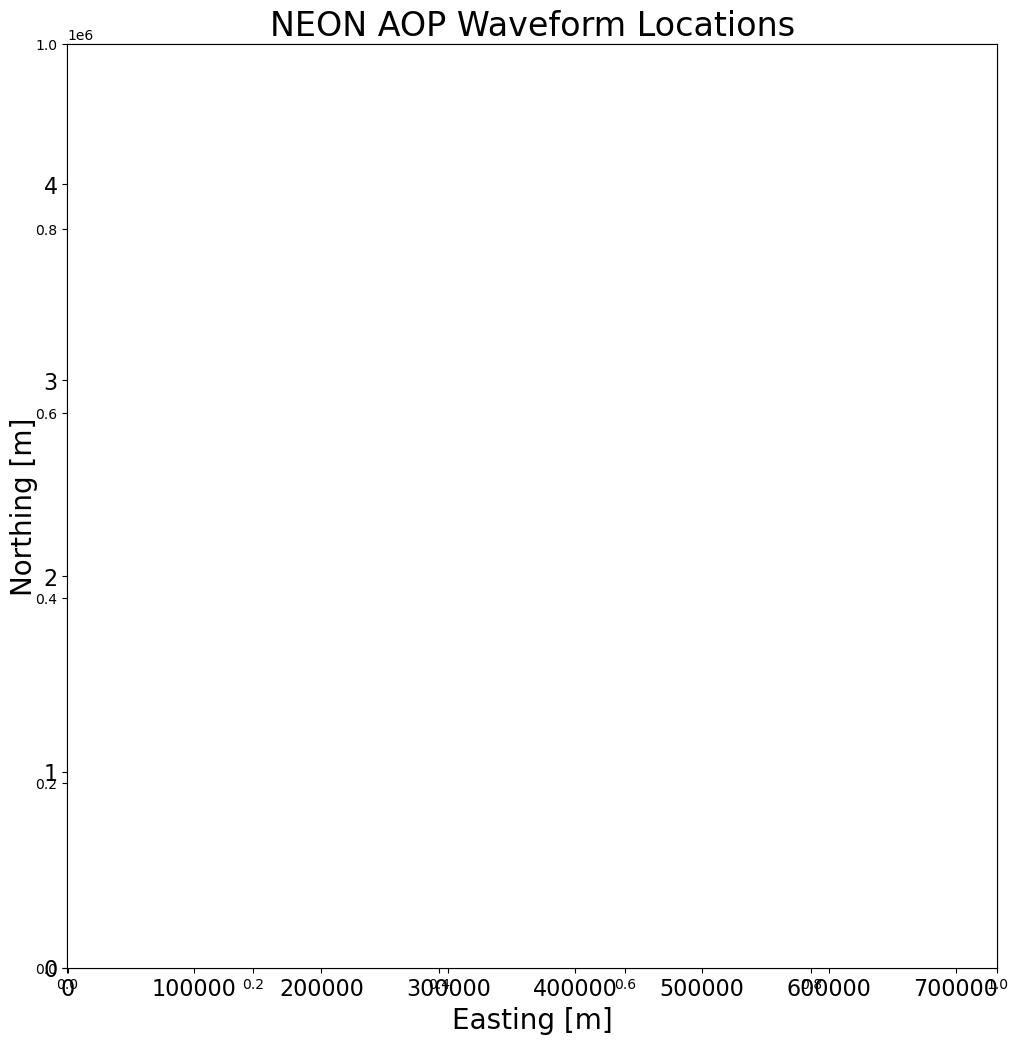

In [20]:
# Plot data coverage
start = time.time()
xmin = np.min(utmEasting_bin0_array) - 100.0
xmax = np.max(utmEasting_bin0_array) + 100.0
ymin = np.min(utmNorthing_bin0_array) - 100.0
ymax = np.max(utmNorthing_bin0_array) + 100.0
print(f"Easting(x) min: {xmin}, Easting(x) max: {xmax}, Northing(y) min: {ymin}, Northing(y) max: {ymax}")

plt.subplots(figsize=(12*1.0, 12*1.0))
ax = plt.axes()
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.tick_params(axis='both',which='major',labelsize=16)
ax.set_title('NEON AOP Waveform Locations', size = 24)
ax.set_xlabel('Easting [m]', size = 20)
ax.set_ylabel('Northing [m]', size = 20)
ax.scatter(waveform_easting_firstreturn_array, waveform_northing_firstreturn_array, c = waveform_rgb_lut1[0:100], cmap = 'rainbow', s = 4, zorder = 2)

print(waveform_easting_firstreturn_array[0])
plt.show() 
end = time.time()
print(f"Processing time {end-start}s")


In [21]:
# Input: Laz file, easting and northing locations of waveform
# Output: Graph of points at those locations
def plot_point_cloud_data(laz_file, x_locations, y_locations):
    
    point_cloud=laspy.read(laz_file)
    point_cloud_xyz = np.round(point_cloud.xyz, decimals=2)
    
    # Retrieve boundaries of location data
    x_loc_min = np.min(x_locations)
    x_loc_max = np.max(x_locations)
    y_loc_min = np.min(y_locations)
    y_loc_max = np.max(y_locations)

    # Get mask from location
    mask = (point_cloud_xyz[:, 0] >= x_loc_min) & (point_cloud_xyz[:, 0] <= x_loc_max) & \
       (point_cloud_xyz[:, 1] >= y_loc_min) & (point_cloud_xyz[:, 1] <= y_loc_max)

    masked_indices = np.where(mask)[0]
    masked_point_cloud = point_cloud_xyz[mask]
    print(masked_point_cloud)
    
    # Plot data
    # Z is elevation
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(masked_point_cloud[:, 0], masked_point_cloud[:, 1], masked_point_cloud[:, 2], color='red', s=5)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_zlabel("Elevation")
    ax.set_title("Waveform Point Cloud Visualization")
    plt.show()

[[7.32929100e+05 4.71749673e+06 3.53620000e+02]
 [7.32929730e+05 4.71749674e+06 3.53620000e+02]
 [7.32930400e+05 4.71749675e+06 3.53370000e+02]]


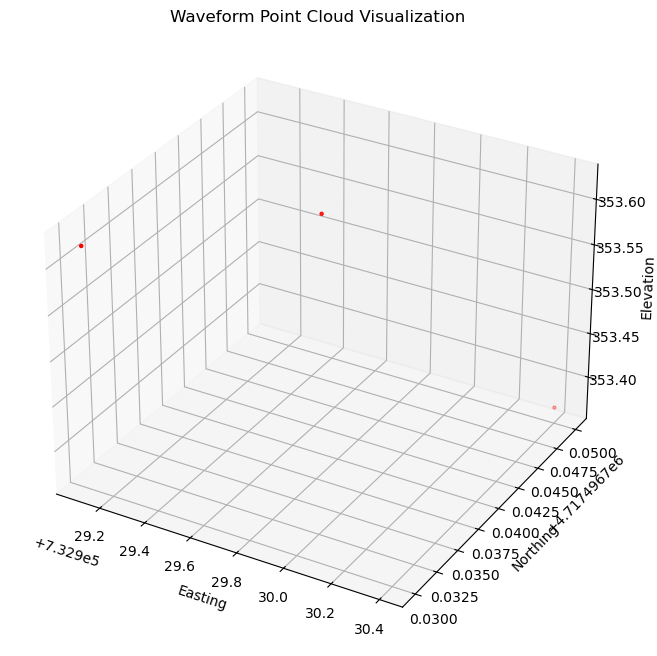

In [244]:
plot_point_cloud_data(point_cloud_file_laz, waveform_x_axis, waveform_y_axis)

In [240]:
def plot_full_point_cloud_data(laz_file):
    point_cloud=laspy.read(laz_file)
    point_cloud_xyz = point_cloud.xyz
    factor=100
    points_dec = point_cloud_xyz[::factor]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_dec[:,0],points_dec[:,1],points_dec[:,2],color='blue',s=4)
    plt.show()

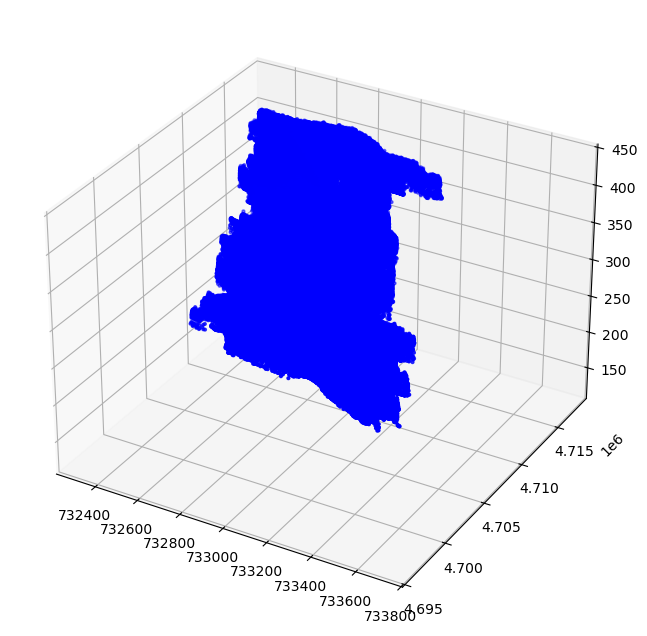

In [241]:
plot_full_point_cloud_data(point_cloud_file_laz)